In [492]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
import random

## helper functions

In [493]:
def get_state_names():
    with open('data/states.txt') as f:
        states = f.readlines()
    f.close()
    states = [[i.split(' - ')[0].lower(), i.split(' - ')[1].split('\n')[0]] for i in states]
    return states

In [494]:
def get_pop_by_zip(soup):
    # total number expected
    print(str(soup.find_all('p')[0]), '(pop_by_zip)')
    num_zips = [int(i) for i in str(soup.find_all('p')[0]).split(' ') if i.isnumeric()][0]

    # get table data
    data = []
    rows = soup.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    data = data[1:-5]
    print(len(data), 'found (pop_by_zip)')
    assert len(data) == num_zips

    # now get pandas df for zip + pop
    pop_by_zip = pd.DataFrame(data)
    pop_by_zip.rename(columns = {0: 'Zip', 3: 'pop'}, inplace = True)
    pop_by_zip['Zip'] = pop_by_zip['Zip'].astype(int)
    pop_by_zip['pop'] = pop_by_zip['pop'].str.replace(',', '')
    pop_by_zip['pop'] = pop_by_zip['pop'].astype(float)
    pop_by_zip = pop_by_zip.set_index('Zip')
    return pop_by_zip

In [495]:
def get_zip_by_latlong(state_abbrev):
    # https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/
    zip_by_latlong = pd.read_csv("data/us_zip_by_latlong.csv", delimiter=';')
    zip_by_latlong = zip_by_latlong.set_index('Zip')
    mask = zip_by_latlong['State'] == state_abbrev
    zip_by_latlong = zip_by_latlong[mask]
    print(len(zip_by_latlong), 'found (zip_by_latlong)')
    return zip_by_latlong

In [496]:
def get_null_values(j):
    return j[j['Latitude'].isnull() | j['Longitude'].isnull() | j['pop'].isnull()]

def drop_null_values(j):
    null_data = get_null_values(j)
    print('\n', len(null_data), 'null values')
    print(null_data[['pop', 'City', 'Latitude', 'Longitude']])
    to_drop = null_data.index
    for i in to_drop:
        j = j.drop(index=i)
    assert 0 == len(get_null_values(j))
    return j

In [497]:
def plot(j, img = ""):
    """
    For convenience, I pretend the map is "flat" by latitude and longitude. 
    The projection has a bit of distortion: 
    farther north, it's actually thinner than the image looks.
    """
    # tutorial from http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
    j.plot(kind="scatter", x="Longitude", y="Latitude",
           s=j['pop']/1000, label="population",
           alpha=0.3, figsize=(10.75, 9.6),
    )
    if str(img):
        plt.imshow(img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.3)

In [498]:
def find_com(joined_data):
    """
    I average the latitudes and longitudes to get the population "center of mass".
    Other projections would put the population "center of mass" somewhere slightly different.
    """
    total_pop = sum(joined_data['pop'])
    lat_avg = sum(joined_data['Latitude']*joined_data['pop']) / total_pop
    long_avg = sum(joined_data['Longitude']*joined_data['pop']) / total_pop
    print('\n', "Total population:", total_pop)
    print("Average latlong:", lat_avg, long_avg)
    
    nearby_zip = ((joined_data['Longitude'] - long_avg)**2 + (joined_data['Latitude'] - lat_avg)**2).sort_values().keys()[0]
    print(joined_data.loc[nearby_zip])
    return (lat_avg, long_avg)

In [499]:
def get_geo_data():
    # https://en.wikipedia.org/wiki/List_of_geographic_centers_of_the_United_States
    with open('data/us_geo_centers.txt') as f:
        centers = f.readlines()
    f.close()

    geo_data = {}
    for c in centers:
        c = c.strip().split('\t')
        state = c[0].strip().split(' (')[0].lower()
        lat = c[2].split('°')[0]
        long = c[2].split('°')[1].split(' ')[1]
        geo_data[state] = [float(lat), 0-float(long)]
    return geo_data

In [500]:
wpr_cache = {}
def get_wpr_soup(state):
    # zip codes are state-separated: https://worldpopulationreview.com/zips/<state>
    if state not in wpr_cache:
        time.sleep(1 + random.random())
        r = requests.get("https://worldpopulationreview.com/zips/" + state)
        soup = BeautifulSoup(r.text, 'html.parser')
        wpr_cache[state] = soup
    return wpr_cache[state]

# Ok, do it!

alabama AL
<p>Alabama has a total of 641 active zip codes.</p> (pop_by_zip)
641 found (pop_by_zip)
863 found (zip_by_latlong)

 5 null values
       pop        City   Latitude  Longitude
Zip                                         
36615  NaN      Mobile  30.641090 -88.062248
36590  NaN    Theodore  30.487953 -88.253278
35074  NaN  Green Pond  33.225840 -87.125150
35457  NaN      Echola  33.301003 -87.771870
35082  NaN     Hollins  33.116909 -86.169800

 Total population: 4854769.0
Average latlong: 33.0098630557977 -86.75305856341686
1                                        Jemison
2                                 Chilton County
pop                                         9116
City                                     Jemison
State                                         AL
Latitude                                 32.9651
Longitude                               -86.7441
Timezone                                      -6
Daylight savings time flag                     1
geopoint           

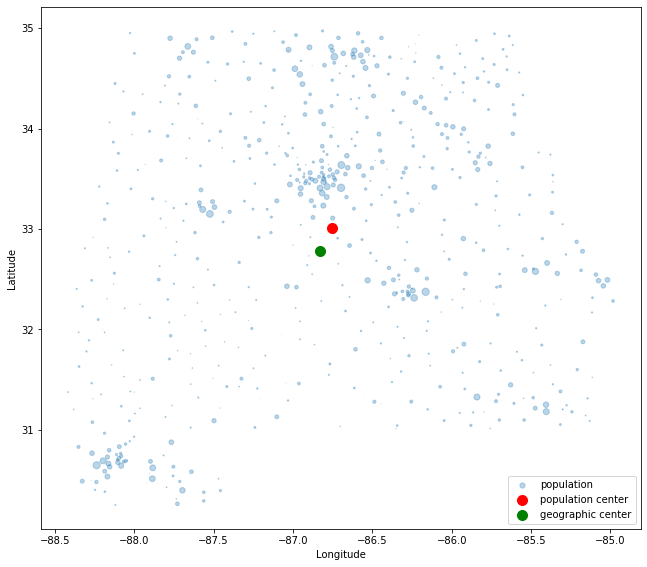

alaska AK
<p>Alaska has a total of 238 active zip codes.</p> (pop_by_zip)
238 found (pop_by_zip)
271 found (zip_by_latlong)

 3 null values
       pop          City   Latitude  Longitude
Zip                                           
99513  NaN     Anchorage  61.214877 -149.88617
99695  NaN     Anchorage  61.402544 -150.57485
99903  NaN  Meyers Chuck  55.742045 -132.25002

 Total population: 737979.0
Average latlong: 61.37638479076777 -149.06966206740154
1                                               Palmer
2                             Matanuska Susitna County
pop                                              30450
City                                            Palmer
State                                               AK
Latitude                                       61.5982
Longitude                                     -149.041
Timezone                                            -9
Daylight savings time flag                           1
geopoint                          61.598203,-1

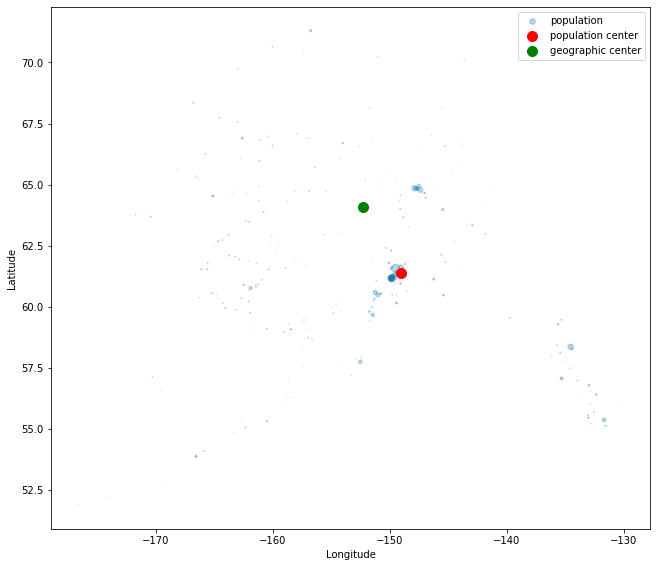

arizona AZ
<p>Arizona has a total of 367 active zip codes.</p> (pop_by_zip)
367 found (pop_by_zip)
538 found (zip_by_latlong)

 10 null values
           pop                      City   Latitude   Longitude
Zip                                                            
85142  65881.0                       NaN        NaN         NaN
86443      NaN         Temple Bar Marina  35.210634 -114.179228
85535      NaN                      Eden  32.963028 -109.918030
85654      NaN                   Rillito  32.417221 -111.171350
85724      NaN                    Tucson  32.240571 -110.944343
86028      NaN  Petrified Forest Natl Pk  35.237487 -109.522950
86433      NaN                    Oatman  35.030577 -114.389280
85341      NaN                 Lukeville  31.970131 -111.890713
85723      NaN                    Tucson  31.970131 -111.890713
85726      NaN                    Tucson  32.202726 -110.945346

 Total population: 6078929.0
Average latlong: 33.39770464567069 -111.89137635023026
1   

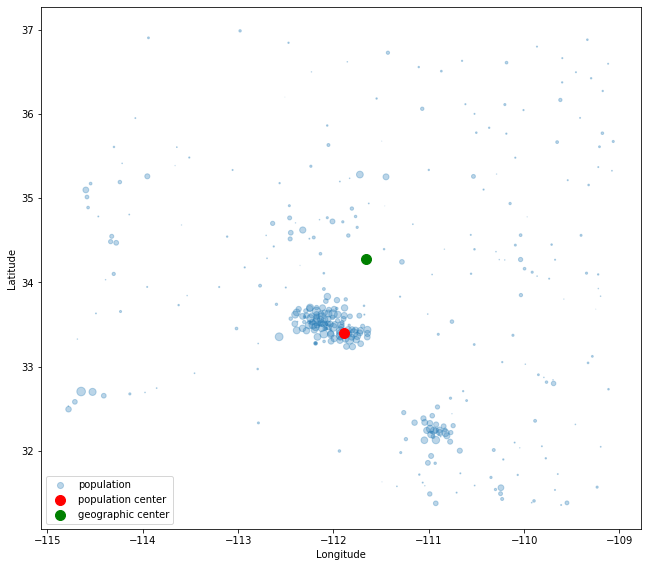

arkansas AR
<p>Arkansas has a total of 590 active zip codes.</p> (pop_by_zip)
590 found (pop_by_zip)
737 found (zip_by_latlong)

 4 null values
       pop               City   Latitude  Longitude
Zip                                                
72119  NaN  North Little Rock  34.801650 -92.259781
72379  NaN          Snow Lake  34.044682 -91.019400
72149  NaN             Searcy  35.247376 -91.731390
72515  NaN              Bexar  36.293095 -92.041700

 Total population: 2964524.0
Average latlong: 35.1781699299975 -92.69318380639153
1                                       Morrilton
2                                   Conway County
pop                                         11472
City                                    Morrilton
State                                          AR
Latitude                                  35.1565
Longitude                                -92.7586
Timezone                                       -6
Daylight savings time flag                      1
geopoint   

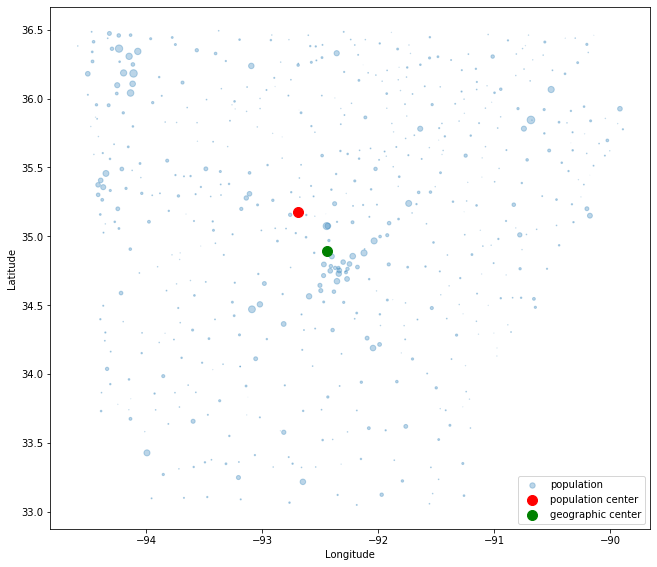

california CA
<p>California has a total of 1741 active zip codes.</p> (pop_by_zip)
1741 found (pop_by_zip)
2716 found (zip_by_latlong)

 23 null values
           pop                      City   Latitude   Longitude
Zip                                                            
95391  16562.0                       NaN        NaN         NaN
92637  16228.0                       NaN        NaN         NaN
90506      NaN                  Torrance  33.786594 -118.298662
91371      NaN            Woodland Hills  33.786594 -118.298662
90831      NaN                Long Beach  33.767817 -118.199401
92364      NaN                    Nipton  35.460190 -115.494670
90747      NaN                    Carson  33.867138 -118.253825
95250      NaN               Sheep Ranch  38.256839 -120.381020
92338      NaN                    Ludlow  34.720285 -116.198200
90079      NaN               Los Angeles  33.786594 -118.298662
91608      NaN            Universal City  34.139397 -118.350340
94850      NaN  

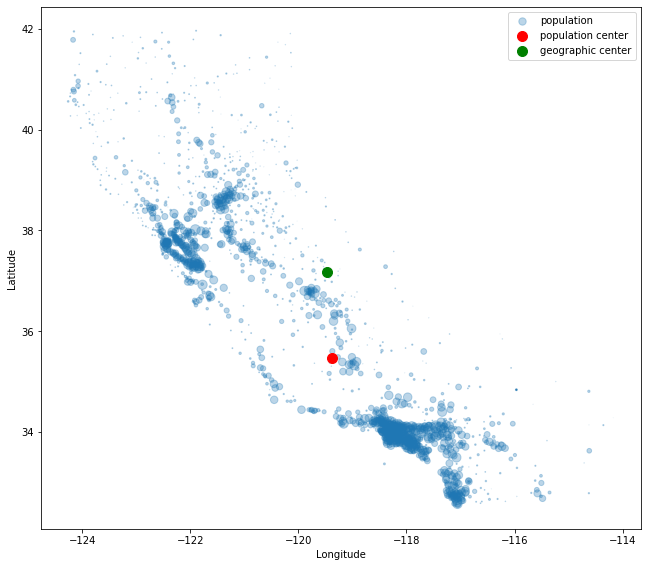

colorado CO
<p>Colorado has a total of 511 active zip codes.</p> (pop_by_zip)
511 found (pop_by_zip)
680 found (zip_by_latlong)

 10 null values
       pop        City   Latitude   Longitude
Zip                                          
80471  NaN  Pinecliffe  39.947386 -105.459269
80419  NaN      Golden  39.522014 -105.223945
81612  NaN       Aspen  39.223416 -106.882774
81642  NaN    Meredith  39.342438 -106.634440
81038  NaN   Fort Lyon  37.955547 -103.072469
80290  NaN      Denver  39.744086 -104.986960
80294  NaN      Denver  39.749436 -104.989480
81633  NaN    Dinosaur  40.377031 -108.398991
80264  NaN      Denver  39.742486 -104.985630
80293  NaN      Denver  39.746286 -104.990080

 Total population: 5322488.0
Average latlong: 39.53851743429012 -105.18437921539147
1                                        Littleton
2                                 Jefferson County
pop                                          44851
City                                     Littleton
State         

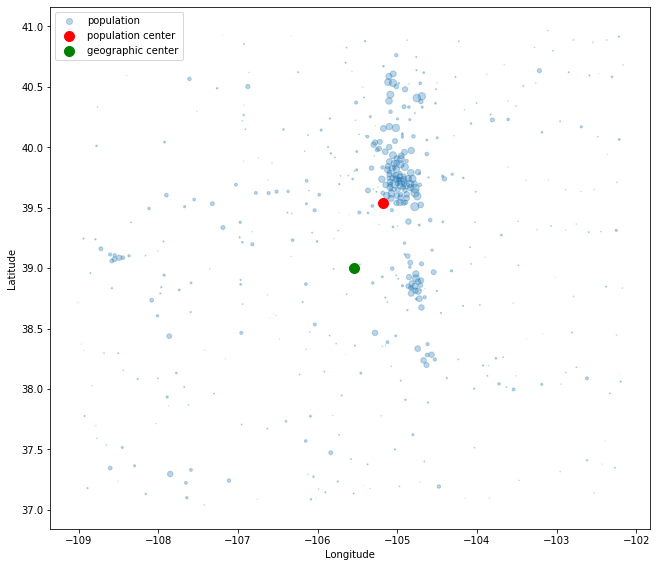

connecticut CT
<p>Connecticut has a total of 277 active zip codes.</p> (pop_by_zip)
277 found (pop_by_zip)
443 found (zip_by_latlong)

 3 null values
      pop           City   Latitude  Longitude
Zip                                           
6020  NaN  Canton Center  41.864597 -72.910030
6160  NaN       Hartford  41.766499 -72.693337
6059  NaN   North Canton  41.937513 -72.920170

 Total population: 3481647.0
Average latlong: 41.49846702012294 -72.86894913856518
1                                        Cheshire
2                                New Haven County
pop                                         29138
City                                     Cheshire
State                                          CT
Latitude                                   41.507
Longitude                                -72.9049
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      41.507049,-72.90489
Name: 6410, dtype: object


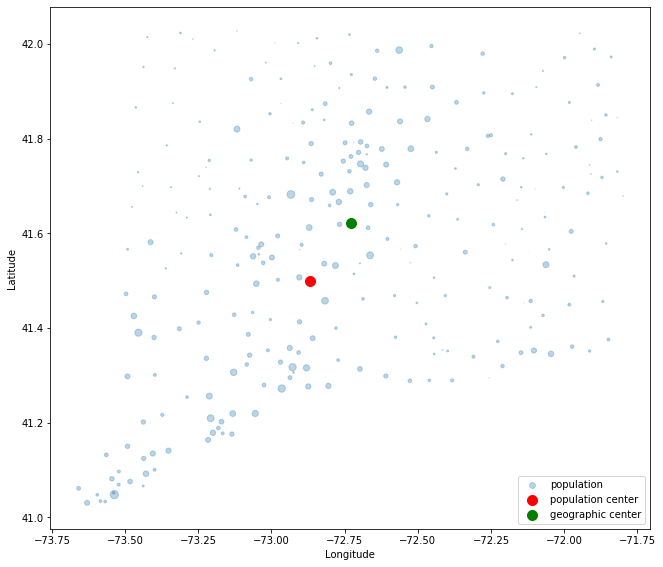

delaware DE
<p>Delaware has a total of 67 active zip codes.</p> (pop_by_zip)
67 found (pop_by_zip)
102 found (zip_by_latlong)

 1 null values
       pop        City   Latitude  Longitude
Zip                                         
19710  NaN  Montchanin  39.788562  -75.58881

 Total population: 949495.0
Average latlong: 39.3434218176515 -75.55156314461897
1                                         Smyrna
2                                    Kent County
pop                                        25568
City                                      Smyrna
State                                         DE
Latitude                                  39.298
Longitude                               -75.5939
Timezone                                      -5
Daylight savings time flag                     1
geopoint                      39.29799,-75.59391
Name: 19977, dtype: object


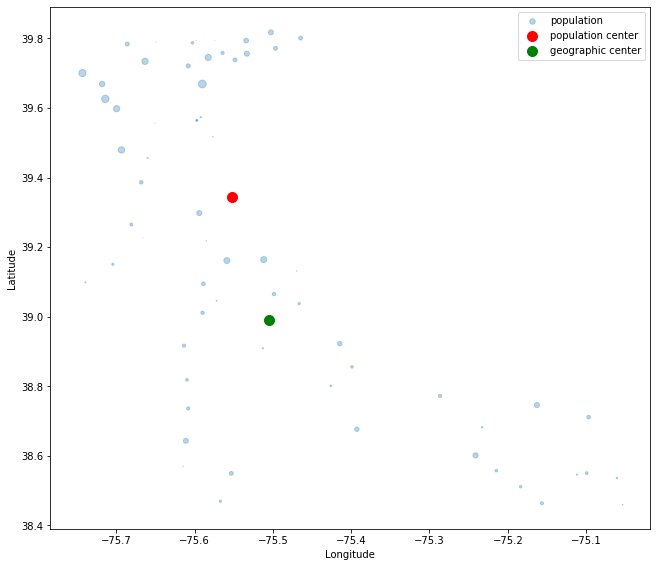

florida FL
<p>Florida has a total of 961 active zip codes.</p> (pop_by_zip)
961 found (pop_by_zip)
1508 found (zip_by_latlong)

 11 null values
           pop                 City   Latitude  Longitude
Zip                                                      
32003  28531.0                  NaN        NaN        NaN
34212  19301.0                  NaN        NaN        NaN
34269   4025.0                  NaN        NaN        NaN
32399      NaN          Tallahassee  30.420146 -84.233310
33855      NaN  Indian Lake Estates  27.798022 -81.357154
34101      NaN               Naples  25.855534 -81.387190
33101      NaN                Miami  25.779076 -80.197820
32530      NaN               Bagdad  30.598564 -87.031496
33945      NaN             Pineland  26.599510 -82.221660
32432      NaN              Cypress  30.713868 -85.077900
34445      NaN               Holder  28.948753 -82.406476

 Total population: 20125226.0
Average latlong: 27.813190199607416 -81.63527994262923
1               

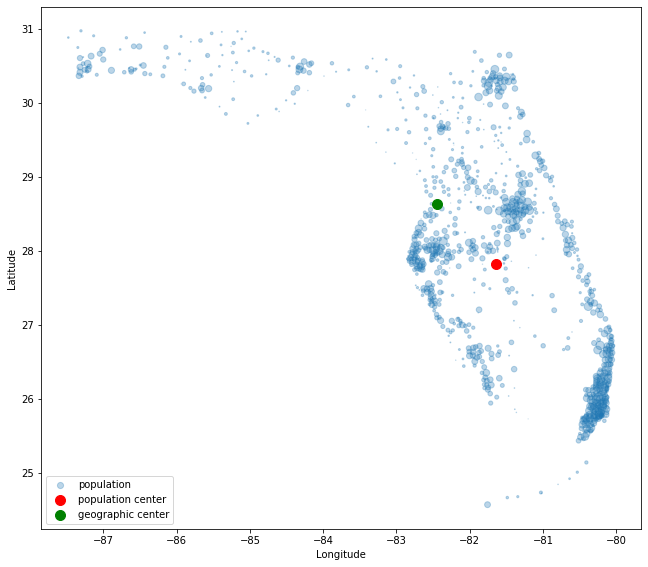

georgia GA
<p>Georgia has a total of 699 active zip codes.</p> (pop_by_zip)
699 found (pop_by_zip)
995 found (zip_by_latlong)

 9 null values
       pop        City   Latitude  Longitude
Zip                                         
31524  NaN   Brunswick  31.221995 -81.482551
30726  NaN  Graysville  34.975939 -85.141600
31304  NaN    Crescent  31.495071 -81.381908
31039  NaN      Howard  32.587537 -84.389500
30334  NaN     Atlanta  33.702657 -84.439127
31213  NaN       Macon  32.839289 -83.638752
30275  NaN     Sargent  33.431181 -84.867330
30475  NaN     Vidalia  32.177513 -82.373889
30164  NaN        Rome  34.333308 -85.233721

 Total population: 10138616.0
Average latlong: 33.42830485957594 -83.88516274255421
1                                       Covington
2                                   Newton County
pop                                         54242
City                                    Covington
State                                          GA
Latitude                    

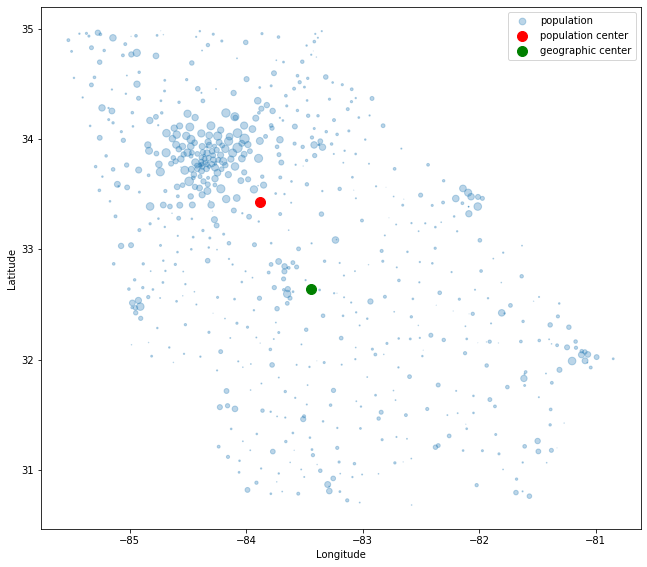

hawaii HI
<p>Hawaii has a total of 94 active zip codes.</p> (pop_by_zip)
94 found (pop_by_zip)
148 found (zip_by_latlong)

 1 null values
       pop      City   Latitude   Longitude
Zip                                        
96850  NaN  Honolulu  24.859832 -168.021815

 Total population: 1422019.0
Average latlong: 21.128741469554203 -157.52990257538053
1                                       Honolulu
2                                Honolulu County
pop                                        29375
City                                    Honolulu
State                                         HI
Latitude                                 21.2946
Longitude                               -157.697
Timezone                                     -10
Daylight savings time flag                     0
geopoint                      21.2946,-157.69721
Name: 96825, dtype: object


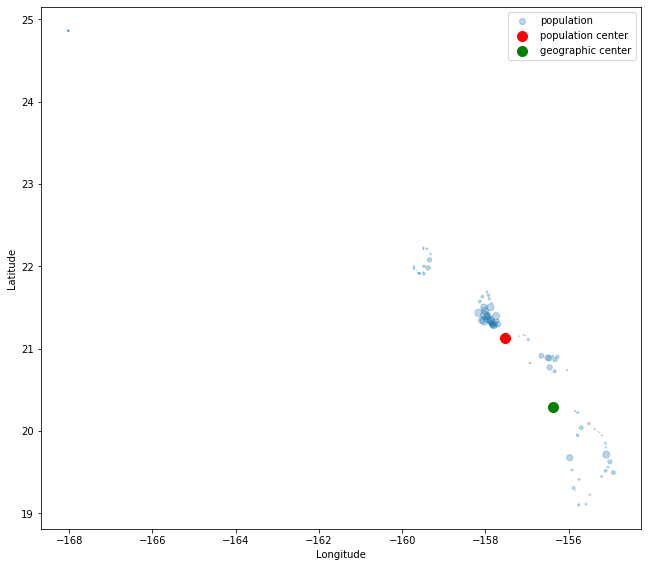

idaho ID
<p>Idaho has a total of 278 active zip codes.</p> (pop_by_zip)
278 found (pop_by_zip)
337 found (zip_by_latlong)

 5 null values
           pop         City   Latitude   Longitude
Zip                                               
83646  59191.0          NaN        NaN         NaN
83874      NaN       Murray  47.626188 -115.832040
83233      NaN       Dingle  42.177359 -111.217381
83826      NaN     Eastport  48.974293 -116.186500
83677      NaN  Yellow Pine  45.017810 -115.553970

 Total population: 1628034.0
Average latlong: 44.24011863276878 -115.20525990675313
1                                          Stanley
2                                    Custer County
pop                                            320
City                                       Stanley
State                                           ID
Latitude                                   44.2482
Longitude                                 -114.936
Timezone                                        -7
Daylight sav

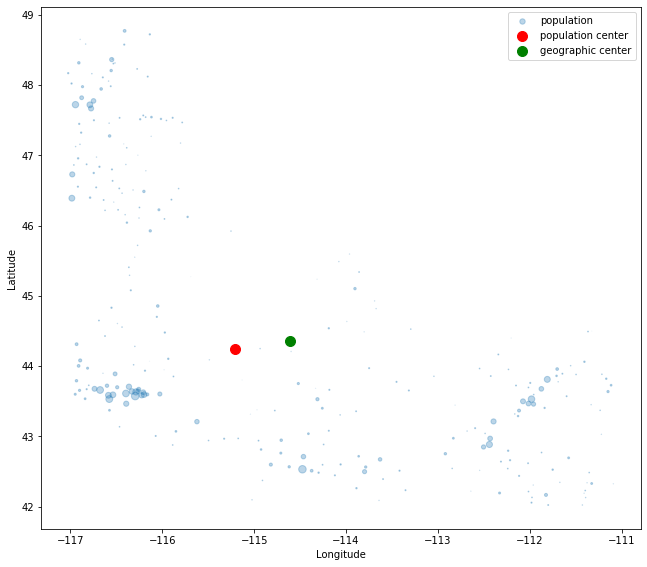

illinois IL
<p>Illinois has a total of 1366 active zip codes.</p> (pop_by_zip)
1366 found (pop_by_zip)
1627 found (zip_by_latlong)

 1 null values
       pop  City   Latitude  Longitude
Zip                                   
62829  NaN  Dale  37.999757  -88.50469

 Total population: 12486426.0
Average latlong: 41.292514915991404 -88.3763200793354
1                                           Mazon
2                                   Grundy County
pop                                          1721
City                                        Mazon
State                                          IL
Latitude                                  41.2434
Longitude                                -88.4032
Timezone                                       -6
Daylight savings time flag                      1
geopoint                      41.243419,-88.40325
Name: 60444, dtype: object


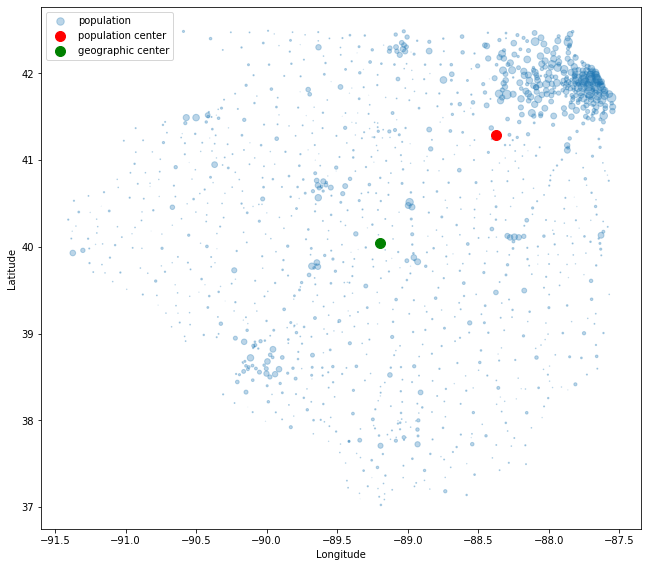

indiana IN
<p>Indiana has a total of 773 active zip codes.</p> (pop_by_zip)
773 found (pop_by_zip)
1032 found (zip_by_latlong)

 5 null values
       pop            City   Latitude  Longitude
Zip                                             
47434  NaN     Harrodsburg  39.012984 -86.545732
47836  NaN       Bridgeton  39.647929 -87.175290
47536  NaN           Fulda  38.112396 -86.836490
47907  NaN  West Lafayette  40.424923 -86.916215
46771  NaN           Mongo  41.665489 -85.267567

 Total population: 6559838.0
Average latlong: 40.14405962207337 -86.25730154262278
1                                        Sheridan
2                                 Hamilton County
pop                                          7415
City                                     Sheridan
State                                          IN
Latitude                                  40.1347
Longitude                                -86.2189
Timezone                                       -5
Daylight savings time flag    

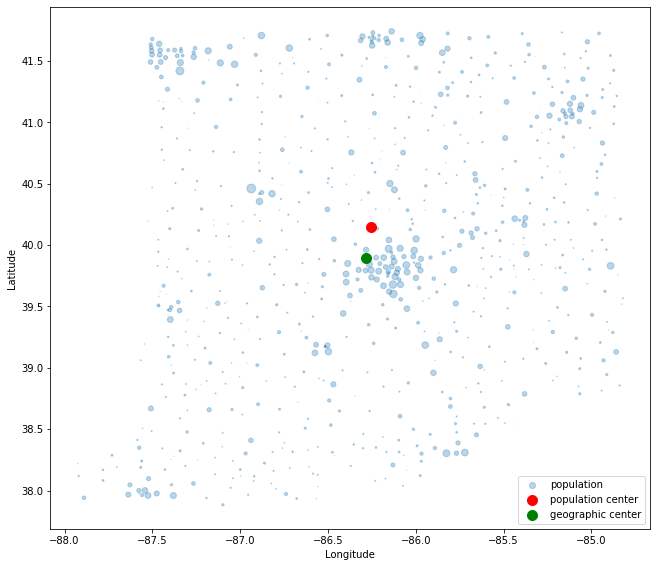

iowa IA
<p>Iowa has a total of 932 active zip codes.</p> (pop_by_zip)
932 found (pop_by_zip)
1084 found (zip_by_latlong)

 2 null values
           pop        City   Latitude  Longitude
Zip                                             
52761  30619.0         NaN        NaN        NaN
50319      NaN  Des Moines  41.592089 -93.603967

 Total population: 3060996.0
Average latlong: 41.945795986644534 -93.04264977838893
1                                       Melbourne
2                                 Marshall County
pop                                          1335
City                                    Melbourne
State                                          IA
Latitude                                  41.9397
Longitude                                -93.0711
Timezone                                       -6
Daylight savings time flag                      1
geopoint                      41.939663,-93.07114
Name: 50162, dtype: object


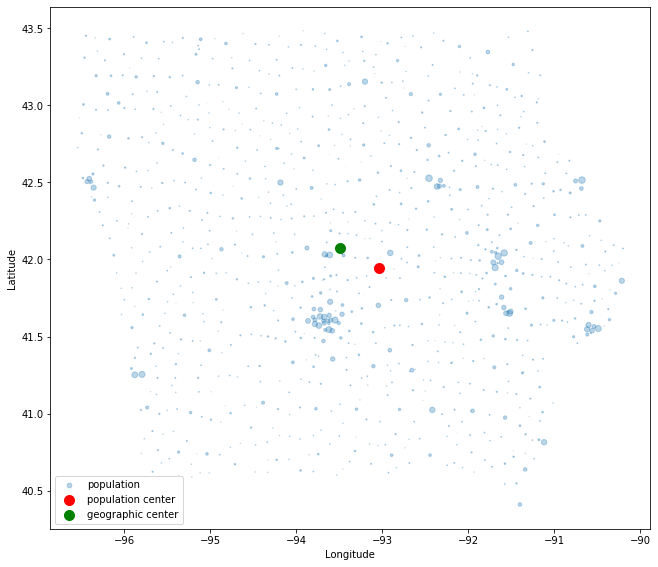

kansas KS
<p>Kansas has a total of 697 active zip codes.</p> (pop_by_zip)
697 found (pop_by_zip)
804 found (zip_by_latlong)

 5 null values
       pop         City   Latitude  Longitude
Zip                                          
66778  NaN       Treece  37.000262 -94.843720
66760  NaN       Opolis  37.344142 -94.621560
67260  NaN      Wichita  37.693588 -97.480419
66115  NaN  Kansas City  39.141419 -94.618780
66118  NaN  Kansas City  39.105854 -94.613290

 Total population: 2908656.0
Average latlong: 38.47636421514198 -96.4231289798501
1                                     Strong City
2                                    Chase County
pop                                           739
City                                  Strong City
State                                          KS
Latitude                                  38.4157
Longitude                                 -96.501
Timezone                                       -6
Daylight savings time flag                      1
geopo

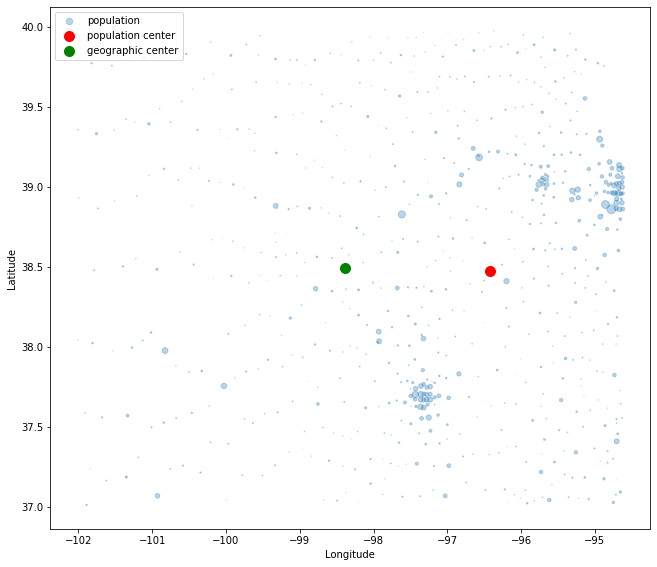

kentucky KY
<p>Kentucky has a total of 769 active zip codes.</p> (pop_by_zip)
769 found (pop_by_zip)
1032 found (zip_by_latlong)

 9 null values
       pop           City   Latitude  Longitude
Zip                                            
42638  NaN         Revelo  36.673236 -84.470950
40434  NaN      Gray Hawk  37.395468 -83.908492
40339  NaN          Keene  37.942941 -84.644180
42370  NaN         Rosine  37.448681 -86.741210
42060  NaN  Lovelaceville  36.968906 -88.828170
40231  NaN     Louisville  38.188962 -85.676819
41762  NaN       Sizerock  37.223635 -83.505990
41848  NaN         Roxana  37.110216 -82.940730
41062  NaN        Minerva  38.719573 -83.910276

 Total population: 4446823.0
Average latlong: 37.83145920997319 -85.25432934934936
1                                         Chaplin
2                                   Nelson County
pop                                           512
City                                      Chaplin
State                                      

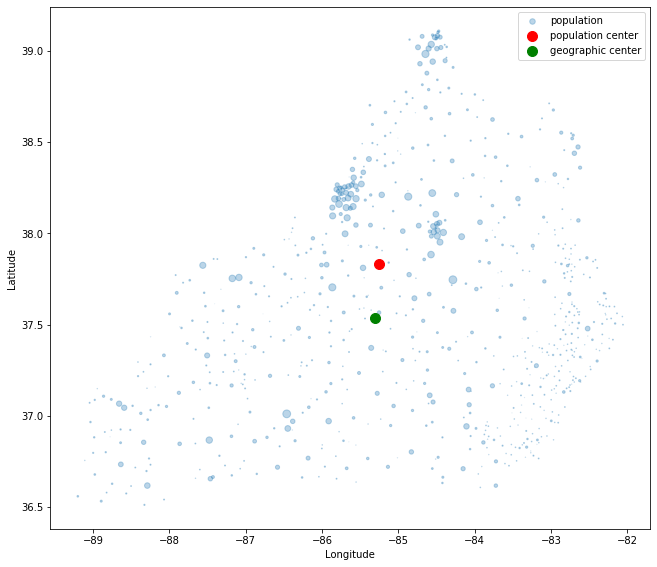

louisiana LA
<p>Louisiana has a total of 515 active zip codes.</p> (pop_by_zip)
515 found (pop_by_zip)
755 found (zip_by_latlong)

 5 null values
       pop         City   Latitude  Longitude
Zip                                          
70163  NaN  New Orleans  29.950060 -90.075320
70836  NaN  Baton Rouge  30.388292 -91.086310
70451  NaN    Natalbany  30.546528 -90.483750
70139  NaN  New Orleans  30.032997 -89.882564
70558  NaN       Milton  30.101464 -92.063380

 Total population: 4663243.0
Average latlong: 30.704044009769373 -91.49245166883051
1                                        New Roads
2                             Pointe Coupee County
pop                                           6487
City                                     New Roads
State                                           LA
Latitude                                   30.7003
Longitude                                 -91.4403
Timezone                                        -6
Daylight savings time flag             

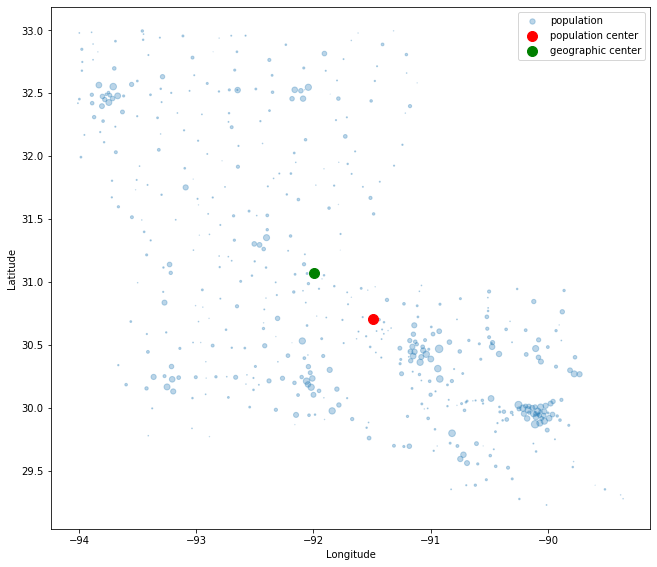

maine ME
<p>Maine has a total of 432 active zip codes.</p> (pop_by_zip)
432 found (pop_by_zip)
523 found (zip_by_latlong)

 7 null values
      pop              City   Latitude  Longitude
Zip                                              
4570  NaN   Squirrel Island  44.021333 -69.523263
4975  NaN           Shawmut  44.624515 -69.586852
4644  NaN        Hulls Cove  44.641873 -68.391481
4940  NaN  Farmington Falls  44.622563 -70.075178
4271  NaN             Paris  44.264111 -70.498513
4629  NaN    East Blue Hill  44.414095 -68.513130
4228  NaN    East Livermore  44.400997 -70.133830

 Total population: 1332721.0
Average latlong: 44.281863824630946 -69.74315391486452
1                                        Randolph
2                                 Kennebec County
pop                                          1996
City                                     Randolph
State                                          ME
Latitude                                  44.2349
Longitude                  

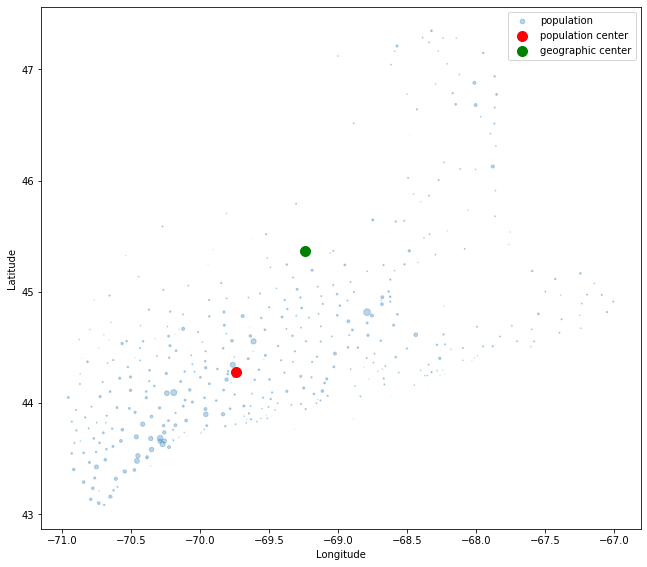

maryland MD
<p>Maryland has a total of 467 active zip codes.</p> (pop_by_zip)
467 found (pop_by_zip)
624 found (zip_by_latlong)

 5 null values
       pop                City   Latitude  Longitude
Zip                                                 
21031  NaN         Hunt Valley  39.487938 -76.659380
20701  NaN  Annapolis Junction  39.127708 -76.792300
21705  NaN           Frederick  39.469961 -77.392139
21240  NaN           Baltimore  39.142793 -76.651589
21105  NaN       Maryland Line  39.712453 -76.650690

 Total population: 5983083.0
Average latlong: 39.13863820983559 -76.8021228752444
1                                          Jessup
2                                   Howard County
pop                                         16601
City                                       Jessup
State                                          MD
Latitude                                  39.1448
Longitude                                -76.7877
Timezone                                       -5
Da

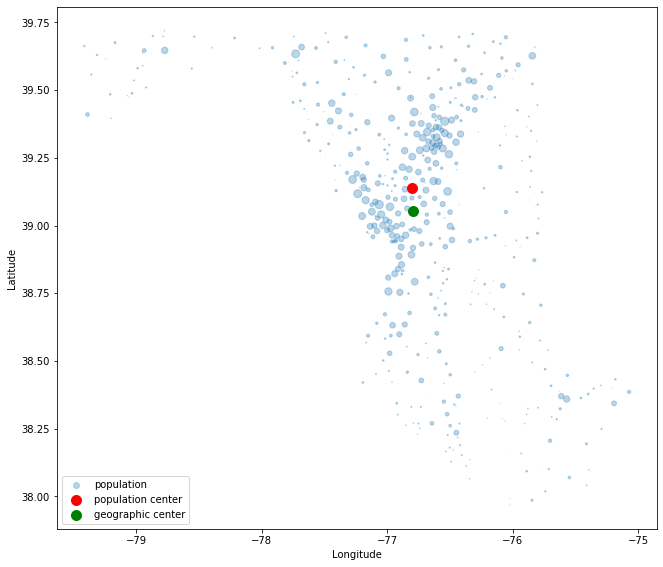

massachusetts MA
<p>Massachusetts has a total of 536 active zip codes.</p> (pop_by_zip)
536 found (pop_by_zip)
766 found (zip_by_latlong)

 3 null values
      pop           City   Latitude  Longitude
Zip                                           
2643  NaN   East Orleans  41.784308 -69.962034
2651  NaN  North Eastham  41.824264 -69.981760
1199  NaN    Springfield  42.119943 -72.604983

 Total population: 6828258.0
Average latlong: 42.27486111707081 -71.35664990317862
1                                          Natick
2                                Middlesex County
pop                                         35763
City                                       Natick
State                                          MA
Latitude                                  42.2908
Longitude                                -71.3537
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      42.290763,-71.35368
Name: 1760, dtype: object


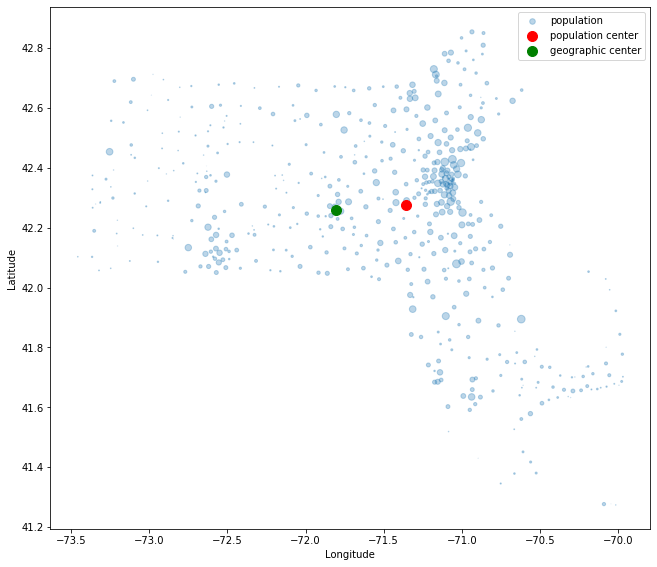

michigan MI
<p>Michigan has a total of 979 active zip codes.</p> (pop_by_zip)
979 found (pop_by_zip)
1203 found (zip_by_latlong)

 11 null values
       pop               City   Latitude  Longitude
Zip                                                
48553  NaN              Flint  42.973627 -83.720306
48243  NaN            Detroit  42.239933 -83.150823
48233  NaN            Detroit  42.239933 -83.150823
48551  NaN              Flint  42.978995 -83.713124
48554  NaN              Flint  42.972244 -83.794630
48667  NaN            Midland  43.647297 -84.387331
48921  NaN            Lansing  42.723735 -84.555629
48242  NaN            Detroit  42.206490 -83.352970
48710  NaN  University Center  43.556574 -83.994328
48143  NaN           Lakeland  42.454366 -83.833720
48397  NaN             Warren  42.491736 -83.040222

 Total population: 9804607.0
Average latlong: 42.87281722519375 -84.21706990267975
1                                         Morrice
2                               Shiawassee C

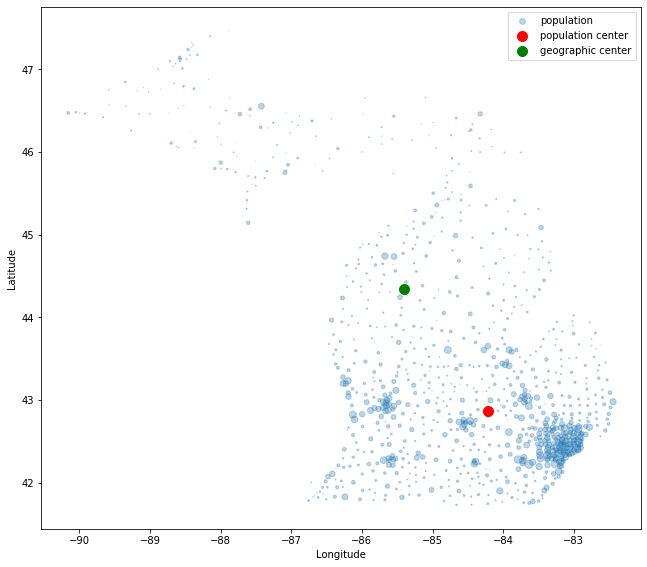

minnesota MN
<p>Minnesota has a total of 884 active zip codes.</p> (pop_by_zip)
884 found (pop_by_zip)
1054 found (zip_by_latlong)

 9 null values
          pop         City   Latitude  Longitude
Zip                                             
55954  1371.0          NaN        NaN        NaN
56129   741.0          NaN        NaN        NaN
56027   719.0          NaN        NaN        NaN
55155     NaN   Saint Paul  44.952165 -93.095518
56593     NaN    Wolf Lake  46.821648 -95.391968
56711     NaN  Angle Inlet  49.342144 -95.035710
55905     NaN    Rochester  44.022513 -92.466826
56658     NaN       Margie  48.278880 -93.755536
56741     NaN   Oak Island  49.242285 -94.840030

 Total population: 5506437.0
Average latlong: 45.19867439208574 -93.57011330008304
1                                          Rogers
2                                 Hennepin County
pop                                         15078
City                                       Rogers
State                         

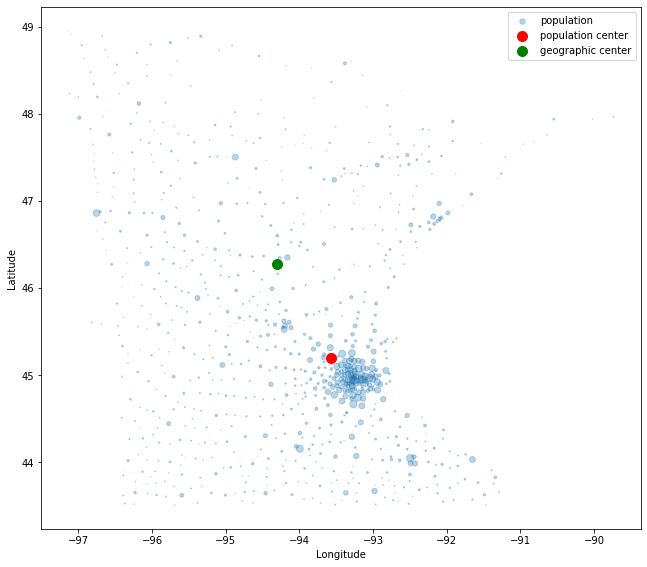

mississippi MS
<p>Mississippi has a total of 423 active zip codes.</p> (pop_by_zip)
423 found (pop_by_zip)
551 found (zip_by_latlong)

 6 null values
          pop        City   Latitude  Longitude
Zip                                            
38852  9090.0         NaN        NaN        NaN
38958     NaN   Swan Lake  33.929206 -90.188462
39269     NaN     Jackson  32.300996 -90.188590
38704     NaN  Greenville  33.253401 -90.918503
39167     NaN        Star  32.096124 -90.061508
39061     NaN  Delta City  33.075557 -90.842980

 Total population: 2979620.0
Average latlong: 32.57703647345835 -89.57706753027065
1                                           Lena
2                                   Leake County
pop                                         3988
City                                        Lena
State                                         MS
Latitude                                 32.5952
Longitude                               -89.6311
Timezone                               

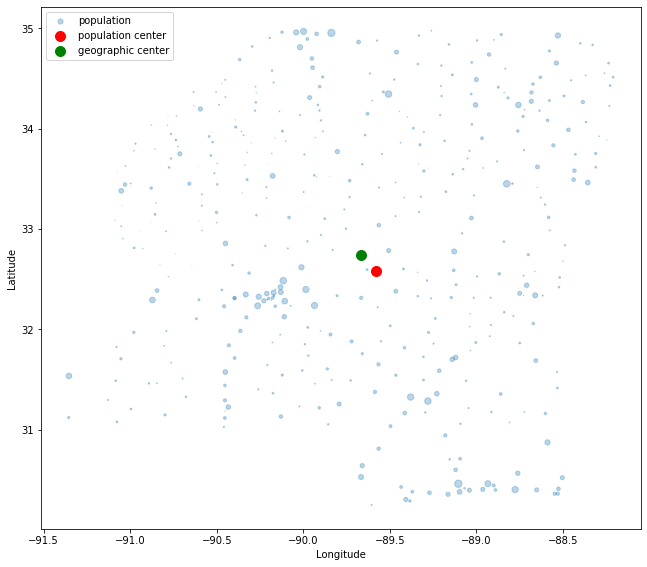

missouri MO
<p>Missouri has a total of 1023 active zip codes.</p> (pop_by_zip)
1023 found (pop_by_zip)
1213 found (zip_by_latlong)

 8 null values
          pop           City   Latitude  Longitude
Zip                                               
65761  1058.0            NaN        NaN        NaN
65733   794.0            NaN        NaN        NaN
64102     NaN    Kansas City  39.093854 -94.604110
63045     NaN     Earth City  38.638318 -90.427118
63902     NaN   Poplar Bluff  36.712451 -90.407013
63155     NaN    Saint Louis  38.653100 -90.243462
64192     NaN    Kansas City  38.953942 -94.523700
65728     NaN  Ponce De Leon  36.874780 -93.343710

 Total population: 6041680.0
Average latlong: 38.42344522452912 -92.22833897339225
1                                   Saint Thomas
2                                    Cole County
pop                                          746
City                                Saint Thomas
State                                         MO
Latitude      

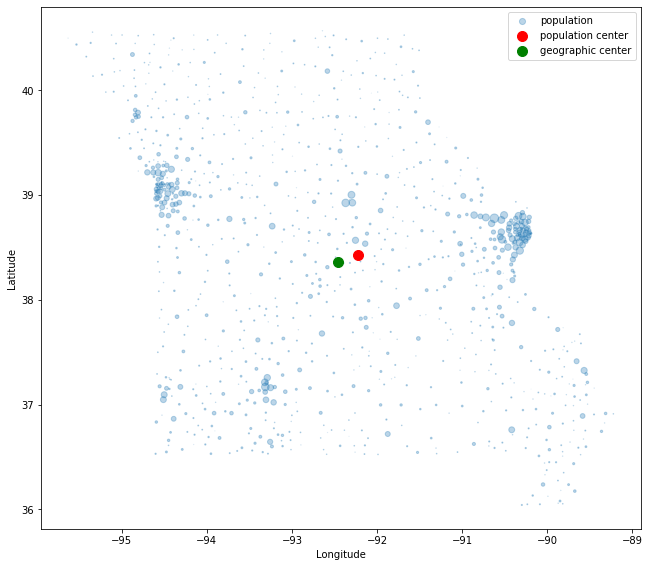

montana MT
<p>Montana has a total of 361 active zip codes.</p> (pop_by_zip)
361 found (pop_by_zip)
417 found (zip_by_latlong)

 0 null values
Empty DataFrame
Columns: [pop, City, Latitude, Longitude]
Index: []

 Total population: 1042359.0
Average latlong: 46.772482289917384 -111.30428905337122
1                             White Sulphur Springs
2                                    Meagher County
pop                                            1717
City                          White Sulphur Springs
State                                            MT
Latitude                                    46.6153
Longitude                                  -111.011
Timezone                                         -7
Daylight savings time flag                        1
geopoint                       46.615309,-111.01063
Name: 59645, dtype: object


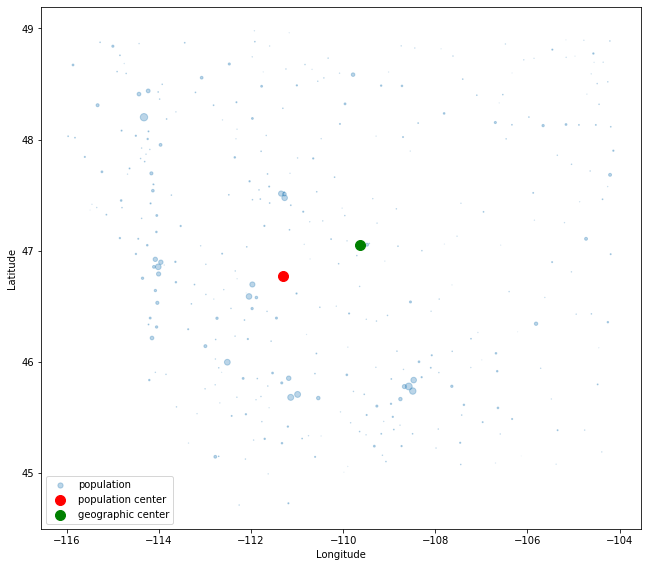

nebraska NE
<p>Nebraska has a total of 580 active zip codes.</p> (pop_by_zip)
580 found (pop_by_zip)
637 found (zip_by_latlong)

 0 null values
Empty DataFrame
Columns: [pop, City, Latitude, Longitude]
Index: []

 Total population: 1904848.0
Average latlong: 41.16947705465533 -97.26634736579628
1                                     Rising City
2                                   Butler County
pop                                           714
City                                  Rising City
State                                          NE
Latitude                                  41.1928
Longitude                                -97.2953
Timezone                                       -6
Daylight savings time flag                      1
geopoint                      41.192785,-97.29532
Name: 68658, dtype: object


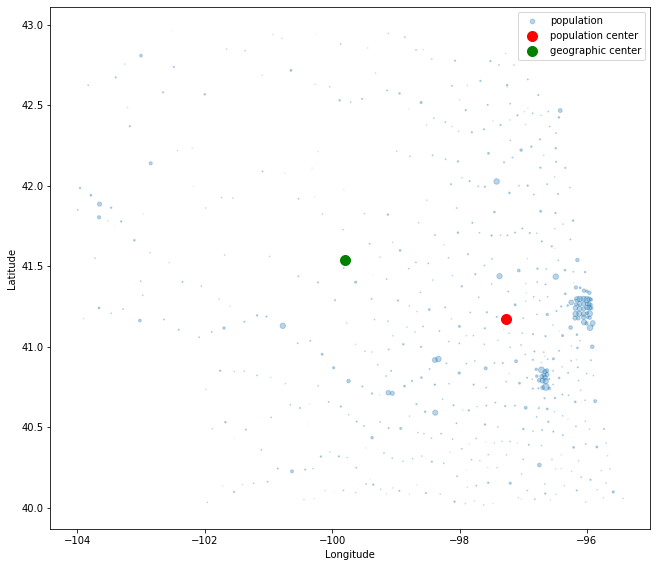

nevada NV
<p>Nevada has a total of 159 active zip codes.</p> (pop_by_zip)
159 found (pop_by_zip)
232 found (zip_by_latlong)

 8 null values
          pop           City   Latitude   Longitude
Zip                                                
89439  1355.0            NaN        NaN         NaN
89831     NaN  Mountain City  41.796309 -116.054890
89702     NaN    Carson City  39.135503 -119.758750
89420     NaN         Luning  38.555308 -118.218180
89826     NaN       Jarbidge  41.905845 -115.435420
89446     NaN     Winnemucca  41.076358 -117.760165
89022     NaN      Manhattan  38.738647 -117.078900
89026     NaN           Jean  35.927901 -114.972061

 Total population: 2618967.0
Average latlong: 37.01716577031861 -116.16790686926333
1                                 Amargosa Valley
2                                      Nye County
pop                                          1407
City                              Amargosa Valley
State                                          NV
Latit

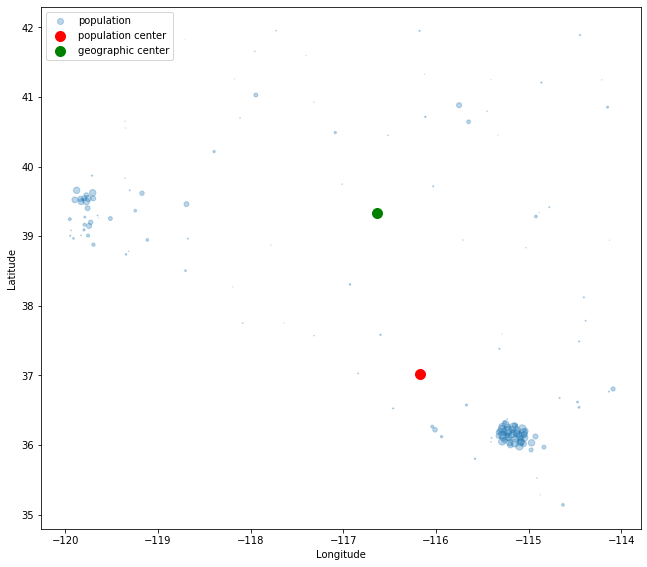

new hampshire NH
<p>New Hampshire has a total of 243 active zip codes.</p> (pop_by_zip)
243 found (pop_by_zip)
305 found (zip_by_latlong)

 0 null values
Empty DataFrame
Columns: [pop, City, Latitude, Longitude]
Index: []

 Total population: 1333880.0
Average latlong: 43.14927988097358 -71.46065900008689
1                                         Suncook
2                                Merrimack County
pop                                         11542
City                                      Suncook
State                                          NH
Latitude                                  43.1525
Longitude                                -71.4365
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      43.152469,-71.43654
Name: 3275, dtype: object


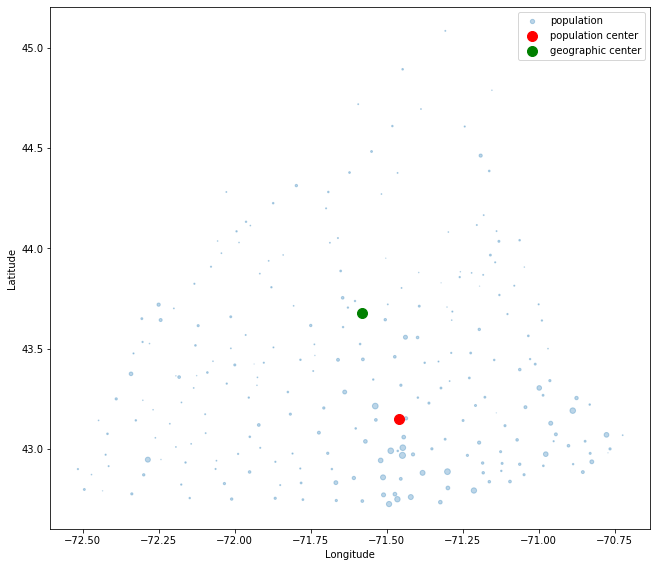

new jersey NJ
<p>New Jersey has a total of 595 active zip codes.</p> (pop_by_zip)
595 found (pop_by_zip)
762 found (zip_by_latlong)

 2 null values
      pop        City   Latitude  Longitude
Zip                                        
7495  NaN      Mahwah  40.948054 -74.083231
7961  NaN  Morristown  40.779750 -74.442797

 Total population: 8881845.0
Average latlong: 40.4360732575647 -74.42647113485747
1                                        Milltown
2                                Middlesex County
pop                                          8488
City                                     Milltown
State                                          NJ
Latitude                                  40.4511
Longitude                                -74.4394
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      40.451105,-74.43938
Name: 8850, dtype: object


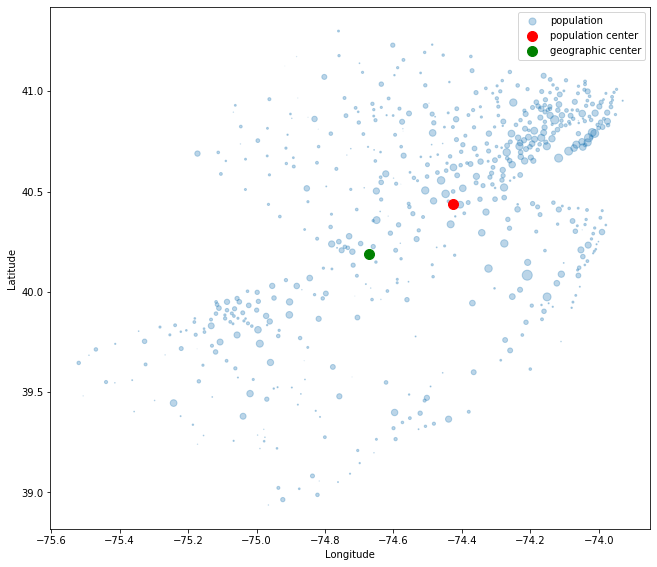

new mexico NM
<p>New Mexico has a total of 365 active zip codes.</p> (pop_by_zip)
365 found (pop_by_zip)
441 found (zip_by_latlong)

 8 null values
          pop          City   Latitude   Longitude
Zip                                               
87328  2411.0           NaN        NaN         NaN
88354     NaN          Weed  32.783249 -105.473060
88033     NaN     Fairacres  32.195630 -107.104610
88417     NaN        Cuervo  35.014908 -104.417780
88355     NaN       Ruidoso  33.330502 -105.693322
87554     NaN        Petaca  36.465416 -106.578513
87750     NaN       Valmora  35.798216 -104.850070
88323     NaN  Fort Stanton  33.492448 -105.530210

 Total population: 2004216.0
Average latlong: 34.64443758366215 -106.33055035168475
1                                          Torreon
2                                  Torrance County
pop                                            373
City                                       Torreon
State                                           NM
La

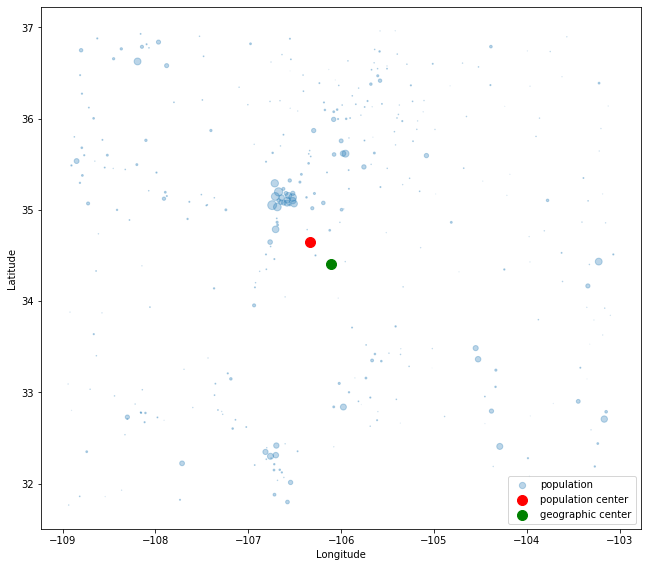

new york NY
<p>New York has a total of 1792 active zip codes.</p> (pop_by_zip)
1792 found (pop_by_zip)
2281 found (zip_by_latlong)

 39 null values
          pop           City   Latitude  Longitude
Zip                                               
10004  3028.0            NaN        NaN        NaN
11359     NaN        Bayside  40.792780 -73.776701
10167     NaN       New York  40.754862 -73.974950
13290     NaN       Syracuse  43.075066 -76.174110
11425     NaN        Jamaica  40.651378 -73.870779
12024     NaN       Brainard  42.494981 -73.510676
10169     NaN       New York  40.754463 -73.976060
12527     NaN        Glenham  41.520249 -73.933259
10171     NaN       New York  40.756099 -73.974010
10110     NaN       New York  40.753987 -73.980811
12007     NaN         Alcove  42.482455 -73.936671
10910     NaN          Arden  41.386195 -74.125718
10173     NaN       New York  40.754302 -73.979550
10112     NaN       New York  40.759291 -73.979790
14893     NaN          Wayne  42.474

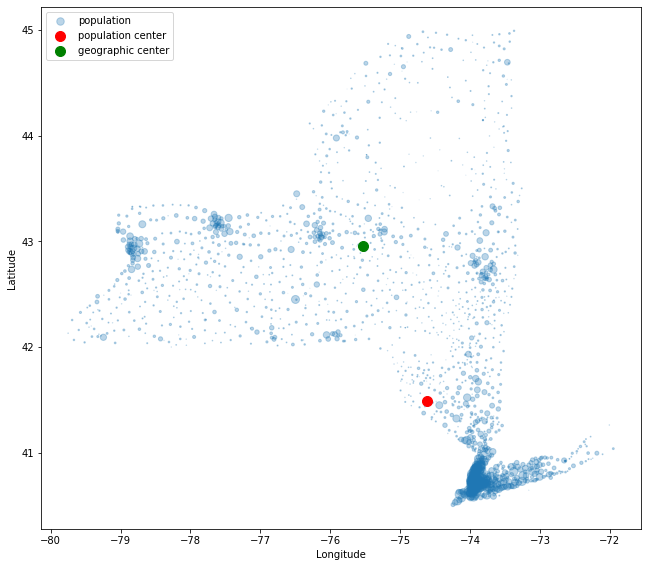

north carolina NC
<p>North Carolina has a total of 802 active zip codes.</p> (pop_by_zip)
802 found (pop_by_zip)
1112 found (zip_by_latlong)

 6 null values
       pop              City   Latitude  Longitude
Zip                                               
28280  NaN         Charlotte  35.260020 -80.804151
28244  NaN         Charlotte  35.260020 -80.804151
28282  NaN         Charlotte  35.224242 -80.844743
28652  NaN       Minneapolis  36.086466 -81.934265
28629  NaN  Glendale Springs  36.343002 -81.375020
28019  NaN          Caroleen  35.279371 -81.794750

 Total population: 10056226.0
Average latlong: 35.535638801733924 -79.66443338020953
1                                       Seagrove
2                                Randolph County
pop                                         5263
City                                    Seagrove
State                                         NC
Latitude                                 35.5333
Longitude                               -79.7102
Timezo

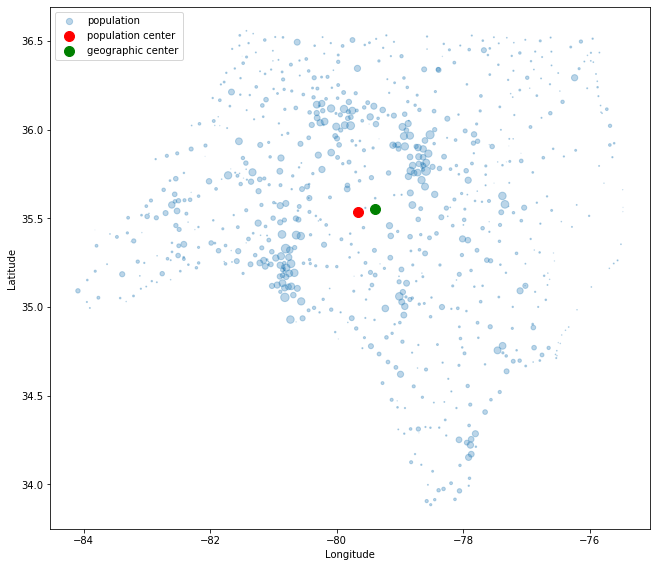

north dakota ND
<p>North Dakota has a total of 383 active zip codes.</p> (pop_by_zip)
383 found (pop_by_zip)
431 found (zip_by_latlong)

 2 null values
       pop      City   Latitude   Longitude
Zip                                        
58505  NaN  Bismarck  46.821260 -100.781310
58702  NaN     Minot  48.336898 -101.451285

 Total population: 751250.0
Average latlong: 47.351712543696436 -99.43594946742505
1                                        Sykeston
2                                    Wells County
pop                                           247
City                                     Sykeston
State                                          ND
Latitude                                  47.4359
Longitude                                -99.4047
Timezone                                       -6
Daylight savings time flag                      1
geopoint                      47.435936,-99.40469
Name: 58486, dtype: object


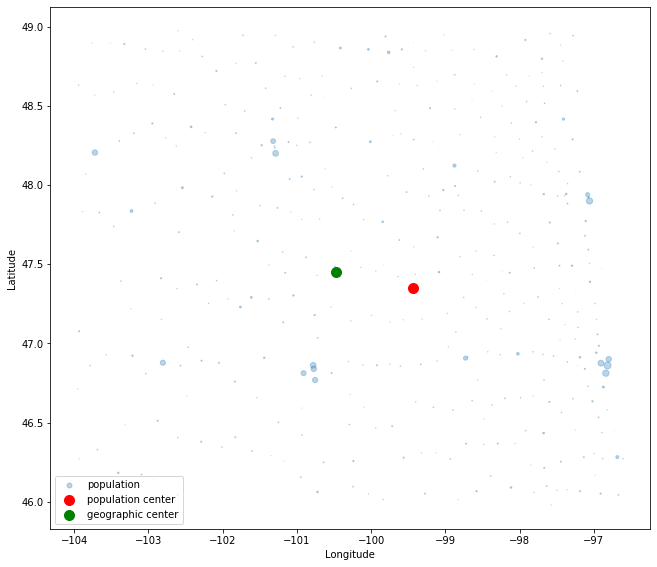

ohio OH
<p>Ohio has a total of 1197 active zip codes.</p> (pop_by_zip)
1197 found (pop_by_zip)
1498 found (zip_by_latlong)

 7 null values
       pop             City   Latitude  Longitude
Zip                                              
44265  NaN         Randolph  41.010907 -81.297727
43733  NaN          Derwent  39.923616 -81.542965
43336  NaN       Middleburg  40.293691 -83.582700
45642  NaN           Jasper  39.047577 -83.053820
43967  NaN          Warnock  40.022806 -80.940930
44881  NaN  Sulphur Springs  40.868645 -82.875027
45624  NaN        Cynthiana  39.172214 -83.348420

 Total population: 11641879.0
Average latlong: 40.443206837233554 -82.77652203027918
1                                         Marengo
2                                   Morrow County
pop                                          6317
City                                      Marengo
State                                          OH
Latitude                                  40.3996
Longitude                

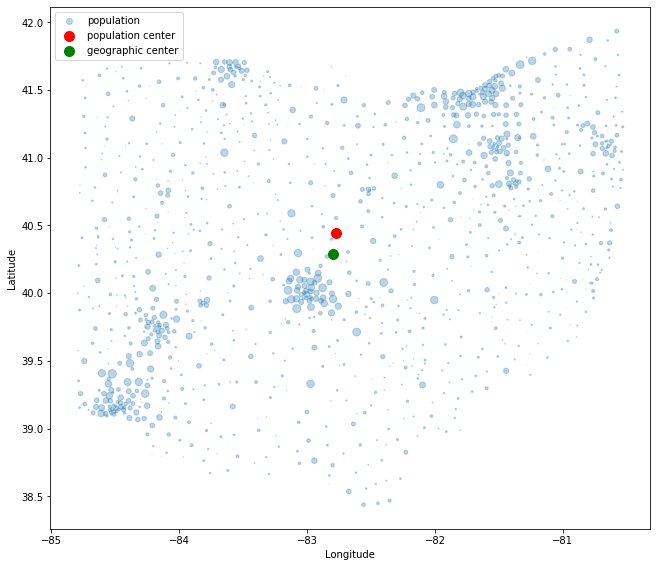

oklahoma OK
<p>Oklahoma has a total of 646 active zip codes.</p> (pop_by_zip)
646 found (pop_by_zip)
795 found (zip_by_latlong)

 2 null values
       pop     City   Latitude  Longitude
Zip                                      
74477  NaN  Wagoner  35.963567 -95.513856
73019  NaN   Norman  35.208566 -97.444510

 Total population: 3887269.0
Average latlong: 35.587810950086094 -96.85336445772919
1                                         Sparks
2                                 Lincoln County
pop                                          684
City                                      Sparks
State                                         OK
Latitude                                 35.6011
Longitude                               -96.7777
Timezone                                      -6
Daylight savings time flag                     1
geopoint                      35.601113,-96.7777
Name: 74869, dtype: object


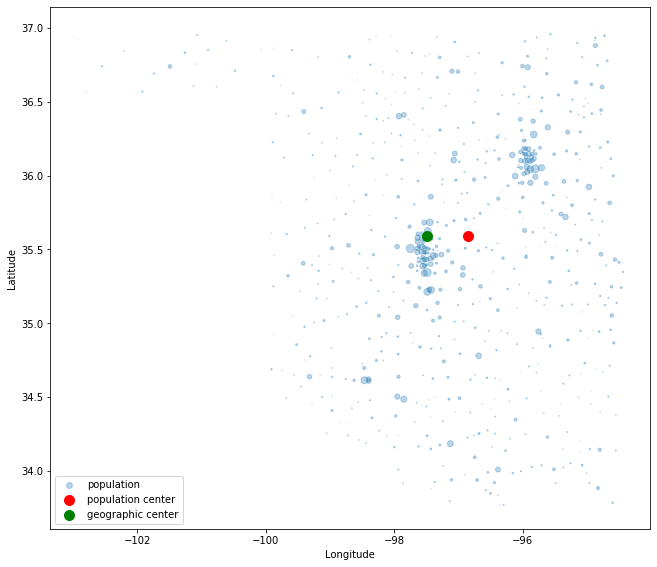

oregon OR
<p>Oregon has a total of 411 active zip codes.</p> (pop_by_zip)
411 found (pop_by_zip)
495 found (zip_by_latlong)

 6 null values
          pop      City   Latitude   Longitude
Zip                                           
97913  4947.0       NaN        NaN         NaN
97910   589.0       NaN        NaN         NaN
97635   138.0       NaN        NaN         NaN
97752     NaN      Post  44.119652 -120.301180
97384     NaN    Mehama  44.790267 -122.618719
97208     NaN  Portland  45.532165 -122.564824

 Total population: 3922512.0
Average latlong: 44.7596532435944 -122.58256530347249
1                                            Lyons
2                                      Linn County
pop                                           2689
City                                         Lyons
State                                           OR
Latitude                                   44.7947
Longitude                                 -122.537
Timezone                                   

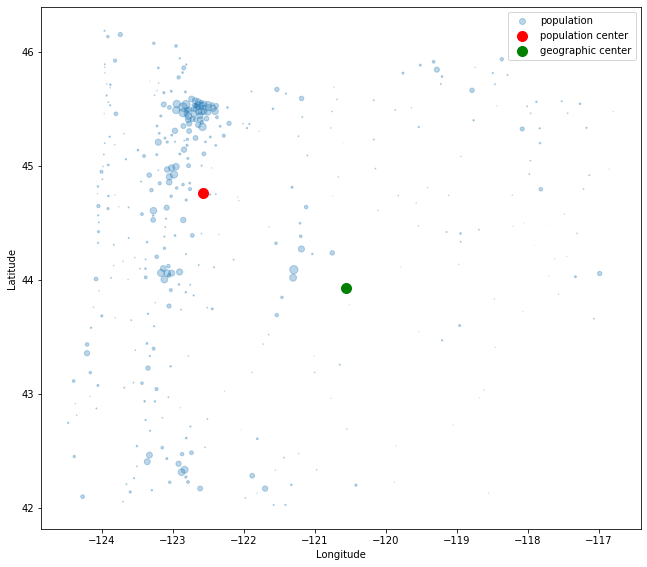

pennsylvania PA
<p>Pennsylvania has a total of 1792 active zip codes.</p> (pop_by_zip)
1792 found (pop_by_zip)
2269 found (zip_by_latlong)

 15 null values
       pop              City   Latitude  Longitude
Zip                                               
19109  NaN      Philadelphia  39.949612 -75.163722
19112  NaN      Philadelphia  39.895677 -75.190440
15290  NaN        Pittsburgh  40.434436 -80.024817
18195  NaN         Allentown  40.579830 -75.579884
18936  NaN   Montgomeryville  40.223216 -75.228290
19542  NaN  Monocacy Station  40.260992 -75.768437
15616  NaN          Armbrust  40.360223 -79.439801
19442  NaN         Kimberton  40.146549 -75.617739
18016  NaN         Bethlehem  40.693376 -75.471156
17822  NaN          Danville  40.967437 -76.604896
15260  NaN        Pittsburgh  40.434436 -80.024817
19367  NaN           Pomeroy  39.964795 -75.882850
19519  NaN         Earlville  40.317896 -75.731440
18068  NaN    Old Zionsville  40.693376 -75.471156
17120  NaN        Harrisburg

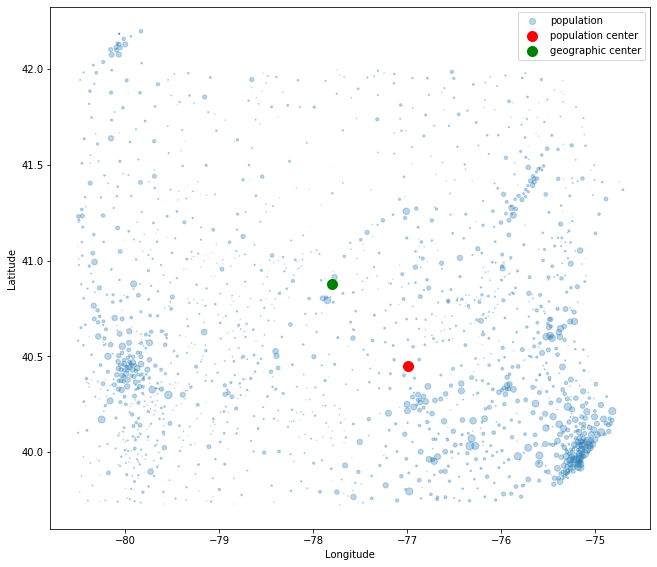

rhode island RI
<p>Rhode Island has a total of 77 active zip codes.</p> (pop_by_zip)
77 found (pop_by_zip)
94 found (zip_by_latlong)

 0 null values
Empty DataFrame
Columns: [pop, City, Latitude, Longitude]
Index: []

 Total population: 1056611.0
Average latlong: 41.75376344512122 -71.45057794303487
1                                      Cranston
2                             Providence County
pop                                       37199
City                                   Cranston
State                                        RI
Latitude                                41.7715
Longitude                              -71.4648
Timezone                                     -5
Daylight savings time flag                    1
geopoint                      41.7715,-71.46485
Name: 2920, dtype: object


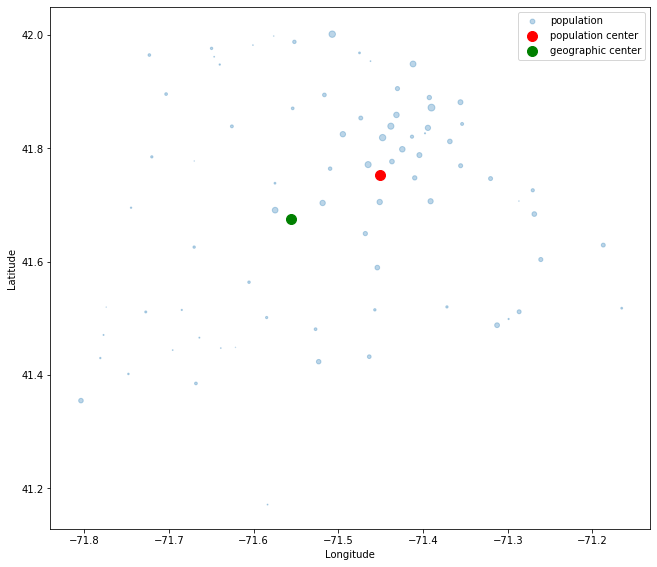

south carolina SC
<p>South Carolina has a total of 421 active zip codes.</p> (pop_by_zip)
421 found (pop_by_zip)
554 found (zip_by_latlong)

 2 null values
       pop          City   Latitude  Longitude
Zip                                           
29912  NaN  Coosawatchie  32.488929 -80.989142
29147  NaN    State Park  34.005992 -80.970766

 Total population: 4893429.0
Average latlong: 34.02282401377622 -81.0017564753723
1                                        Columbia
2                                 Richland County
pop                                         18709
City                                     Columbia
State                                          SC
Latitude                                   34.028
Longitude                                -81.0001
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      34.027955,-81.00008
Name: 29204, dtype: object


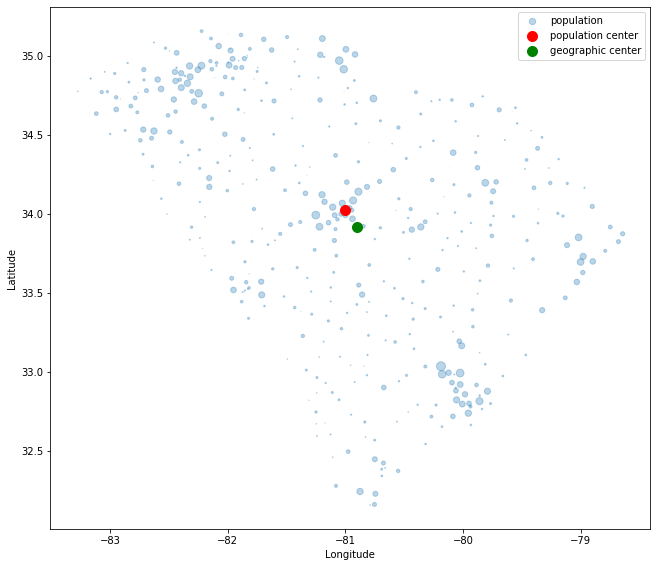

south dakota SD
<p>South Dakota has a total of 371 active zip codes.</p> (pop_by_zip)
371 found (pop_by_zip)
431 found (zip_by_latlong)

 2 null values
          pop   City   Latitude   Longitude
Zip                                        
57638  1817.0    NaN        NaN         NaN
57776     NaN  Redig  45.578941 -103.493668

 Total population: 862195.0
Average latlong: 44.00268788457598 -98.98406083353656
1                                     Gann Valley
2                                  Buffalo County
pop                                           108
City                                  Gann Valley
State                                          SD
Latitude                                  44.0704
Longitude                                -99.0133
Timezone                                       -6
Daylight savings time flag                      1
geopoint                      44.070421,-99.01332
Name: 57341, dtype: object


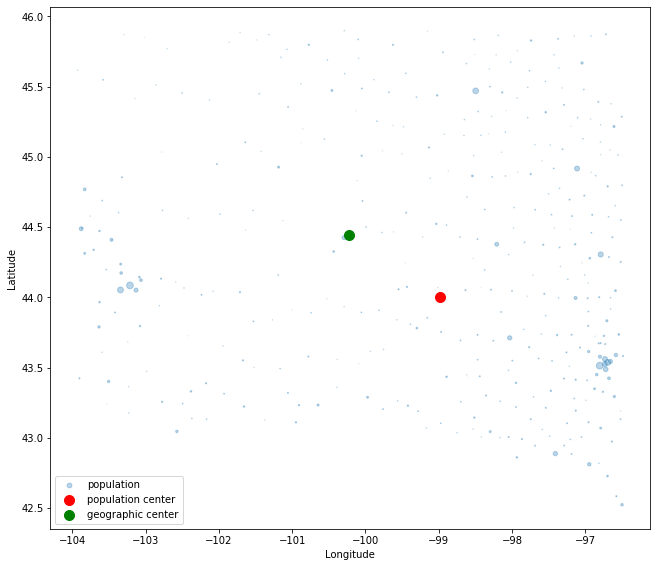

tennessee TN
<p>Tennessee has a total of 627 active zip codes.</p> (pop_by_zip)
627 found (pop_by_zip)
816 found (zip_by_latlong)

 9 null values
           pop       City   Latitude  Longitude
Zip                                            
38063  16536.0        NaN        NaN        NaN
38079   5264.0        NaN        NaN        NaN
38041   4816.0        NaN        NaN        NaN
37730      NaN      Eagan  36.553851 -83.975030
37246      NaN  Nashville  36.158606 -86.789998
38131      NaN    Memphis  35.063236 -89.994030
37243      NaN  Nashville  36.167606 -86.784498
38029      NaN  Ellendale  35.201738 -89.971538
38132      NaN    Memphis  35.073545 -89.997880

 Total population: 6591659.0
Average latlong: 35.812331192575364 -86.33785032598732
1                                    Murfreesboro
2                               Rutherford County
pop                                         17835
City                                 Murfreesboro
State                                    

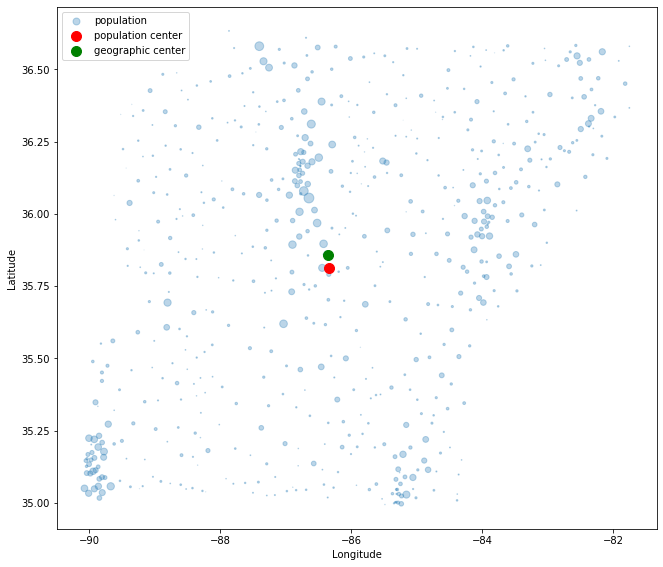

texas TX
<p>Texas has a total of 1929 active zip codes.</p> (pop_by_zip)
1929 found (pop_by_zip)
2743 found (zip_by_latlong)

 20 null values
           pop           City   Latitude   Longitude
Zip                                                 
78542  75569.0            NaN        NaN         NaN
79922   8236.0            NaN        NaN         NaN
76957      NaN           Wall  31.359844 -100.206705
76874      NaN      Roosevelt  30.480128 -100.117500
77507      NaN       Pasadena  29.624686  -95.061110
78029      NaN      Kerrville  30.033226  -99.140974
77201      NaN        Houston  29.833990  -95.434241
79058      NaN      Masterson  35.837775 -101.892846
77342      NaN     Huntsville  30.781280  -95.595270
77428      NaN    Collegeport  28.718954  -96.169690
77973      NaN       Mcfaddin  28.532052  -96.990200
78001      NaN  Artesia Wells  28.265415  -99.282100
75270      NaN         Dallas  32.781330  -96.801980
75858      NaN       Ratcliff  31.369811  -95.091840
75390     

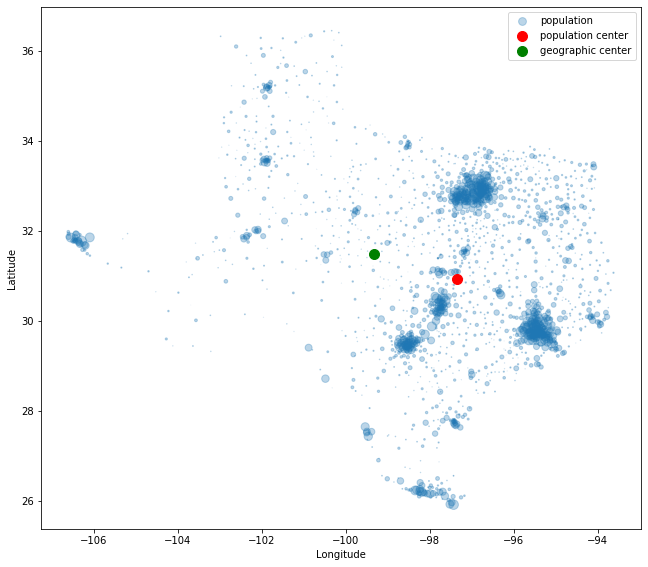

utah UT
<p>Utah has a total of 284 active zip codes.</p> (pop_by_zip)
284 found (pop_by_zip)
356 found (zip_by_latlong)

 4 null values
          pop            City   Latitude   Longitude
Zip                                                 
84536  1869.0             NaN        NaN         NaN
84180     NaN  Salt Lake City  40.770248 -111.900770
84515     NaN           Cisco  38.999877 -109.615008
84304     NaN  Cache Junction  41.832776 -111.997380

 Total population: 2889971.0
Average latlong: 40.393906246859565 -111.92945178502217
1                                             Lehi
2                                      Utah County
pop                                          62382
City                                          Lehi
State                                           UT
Latitude                                   40.3666
Longitude                                 -111.891
Timezone                                        -7
Daylight savings time flag                       1
g

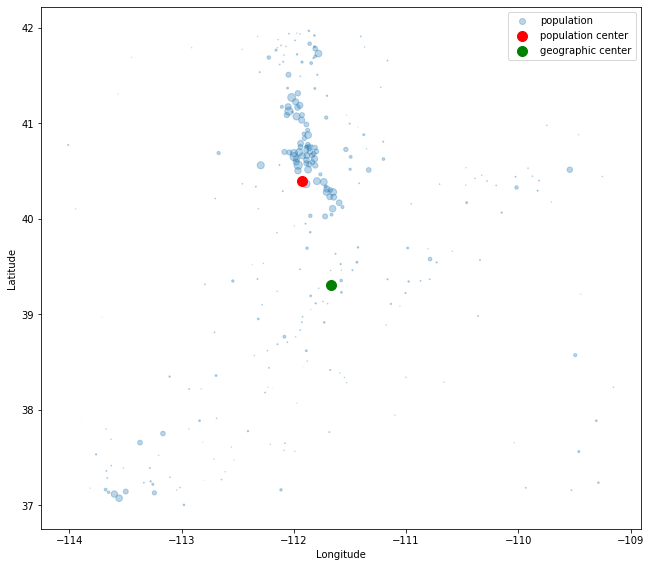

vermont VT
<p>Vermont has a total of 254 active zip codes.</p> (pop_by_zip)
254 found (pop_by_zip)
326 found (zip_by_latlong)

 1 null values
      pop              City   Latitude  Longitude
Zip                                              
5481  NaN  Saint Albans Bay  44.824855 -72.895849

 Total population: 615465.0
Average latlong: 44.10061790940186 -72.81597832661812
1                                          Warren
2                               Washington County
pop                                          1613
City                                       Warren
State                                          VT
Latitude                                  44.1069
Longitude                                -72.8582
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      44.106922,-72.85816
Name: 5674, dtype: object


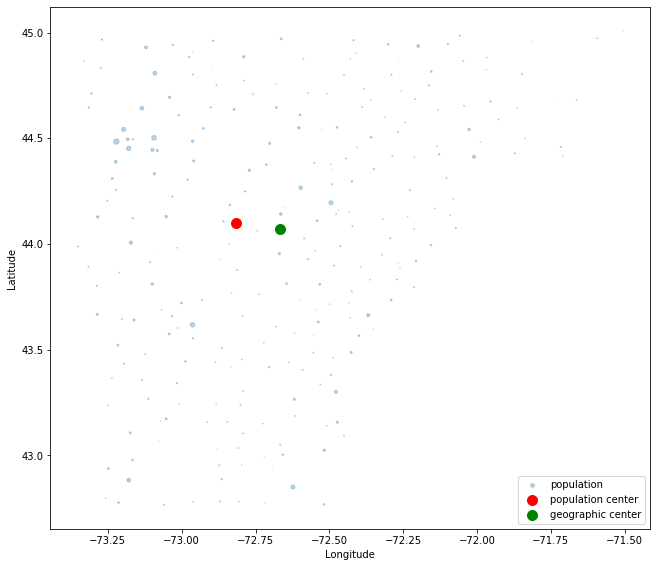

virginia VA
<p>Virginia has a total of 892 active zip codes.</p> (pop_by_zip)
892 found (pop_by_zip)
1275 found (zip_by_latlong)

 6 null values
           pop       City   Latitude  Longitude
Zip                                            
23114  18540.0        NaN        NaN        NaN
22035      NaN    Fairfax  38.855715 -77.361633
23250      NaN   Richmond  37.507498 -77.332916
22185      NaN     Vienna  38.831813 -77.288755
22214      NaN  Arlington  38.880811 -77.112950
24316      NaN  Broadford  36.937195 -81.676170

 Total population: 8293183.0
Average latlong: 37.842503621864395 -77.79230333318615
1                                      Montpelier
2                                  Hanover County
pop                                          6830
City                                   Montpelier
State                                          VA
Latitude                                  37.8139
Longitude                                -77.6895
Timezone                            

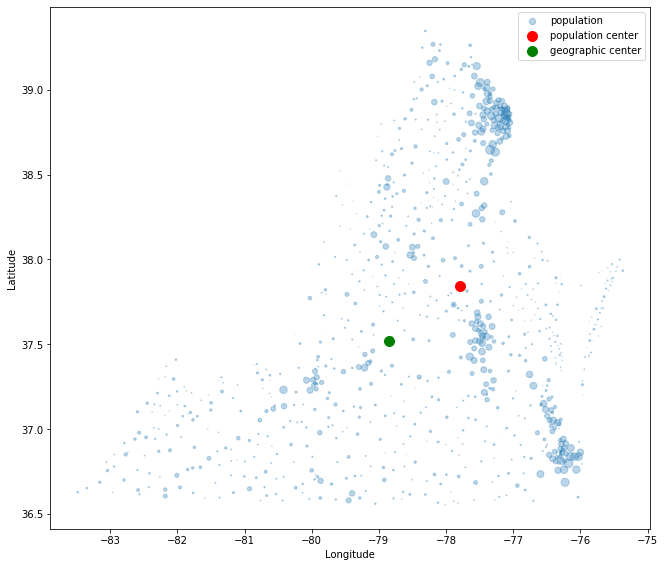

washington WA
<p>Washington has a total of 592 active zip codes.</p> (pop_by_zip)
592 found (pop_by_zip)
737 found (zip_by_latlong)

 12 null values
           pop           City   Latitude   Longitude
Zip                                                 
99362  41456.0            NaN        NaN         NaN
99128    316.0            NaN        NaN         NaN
98929      NaN  Goose Prairie  46.915735 -121.241591
99020      NaN       Marshall  47.563191 -117.495900
98559      NaN         Malone  46.959091 -123.325950
98562      NaN        Moclips  47.254009 -124.207890
98154      NaN        Seattle  47.606320 -122.333570
98430      NaN    Camp Murray  47.066193 -122.113223
98238      NaN         Conway  48.337796 -122.345170
99164      NaN        Pullman  46.838747 -117.644337
98158      NaN        Seattle  47.432251 -121.803388
98174      NaN        Seattle  47.604718 -122.335230

 Total population: 7055182.0
Average latlong: 47.3340599898338 -121.64303977348752
1                        

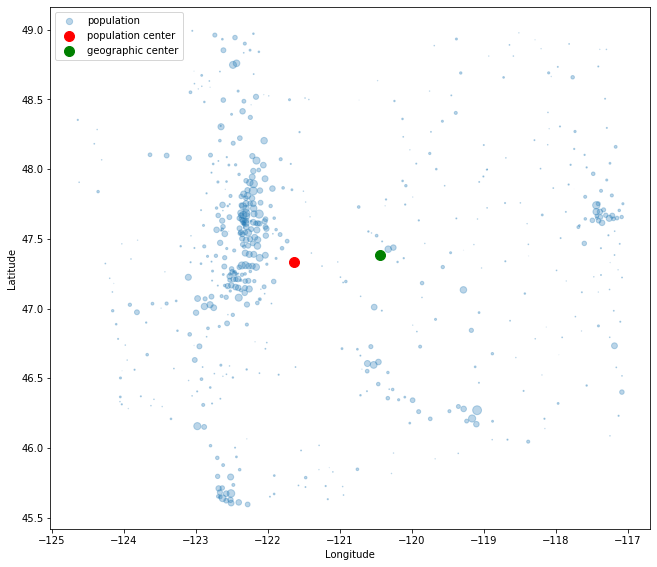

west virginia WV
<p>West Virginia has a total of 703 active zip codes.</p> (pop_by_zip)
703 found (pop_by_zip)
940 found (zip_by_latlong)

 2 null values
       pop        City   Latitude  Longitude
Zip                                         
25002  NaN       Alloy  38.129903 -81.258820
25305  NaN  Charleston  38.335798 -81.612344

 Total population: 1780169.0
Average latlong: 38.79431659081361 -80.76257820853627
1                                        Exchange
2                                  Braxton County
pop                                           399
City                                     Exchange
State                                          WV
Latitude                                   38.788
Longitude                                -80.7329
Timezone                                       -5
Daylight savings time flag                      1
geopoint                      38.788013,-80.73291
Name: 26619, dtype: object


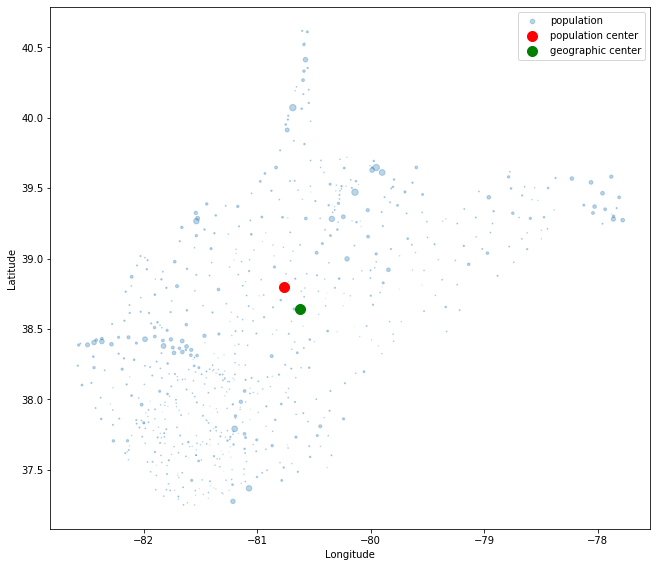

wisconsin WI
<p>Wisconsin has a total of 772 active zip codes.</p> (pop_by_zip)
772 found (pop_by_zip)
940 found (zip_by_latlong)

 3 null values
       pop       City   Latitude  Longitude
Zip                                        
54561  NaN  Star Lake  46.058408 -89.451600
53031  NaN    Hingham  43.639395 -87.915705
53792  NaN    Madison  43.069560 -89.423861

 Total population: 5750863.0
Average latlong: 43.71766872338669 -89.03129910216205
1                                        Markesan
2                               Green Lake County
pop                                          4371
City                                     Markesan
State                                          WI
Latitude                                  43.7276
Longitude                                -89.0257
Timezone                                       -6
Daylight savings time flag                      1
geopoint                      43.727646,-89.02574
Name: 53946, dtype: object


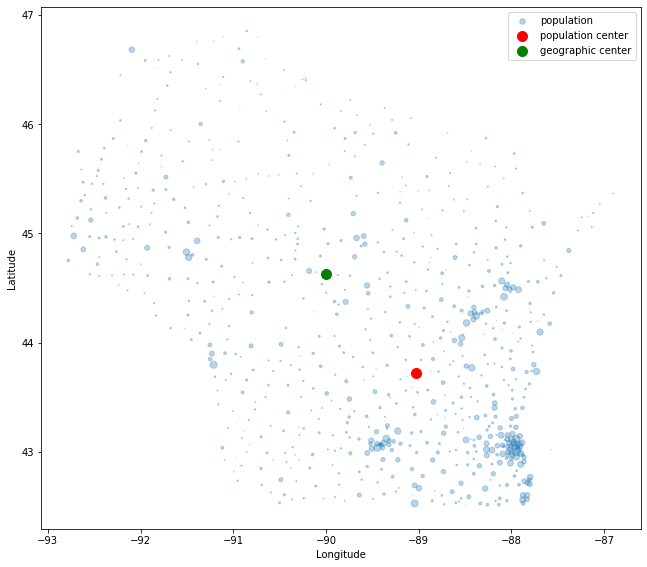

wyoming WY
<p>Wyoming has a total of 177 active zip codes.</p> (pop_by_zip)
177 found (pop_by_zip)
199 found (zip_by_latlong)

 10 null values
          pop          City   Latitude   Longitude
Zip                                               
82082  1696.0           NaN        NaN         NaN
83120   778.0           NaN        NaN         NaN
82063   214.0           NaN        NaN         NaN
83121     NaN      Frontier  41.814385 -110.537430
82638     NaN        Hiland  42.966192 -106.807047
82936     NaN     Lontetree  41.081086 -110.223910
82646     NaN       Natrona  42.966192 -106.807047
82630     NaN       Arminto  42.966192 -106.807047
82715     NaN  Four Corners  43.840033 -104.568128
82061     NaN   Horse Creek  41.422733 -105.198810

 Total population: 579021.0
Average latlong: 42.69819057155096 -107.02378232536806
1                                          Alcova
2                                  Natrona County
pop                                           246
City       

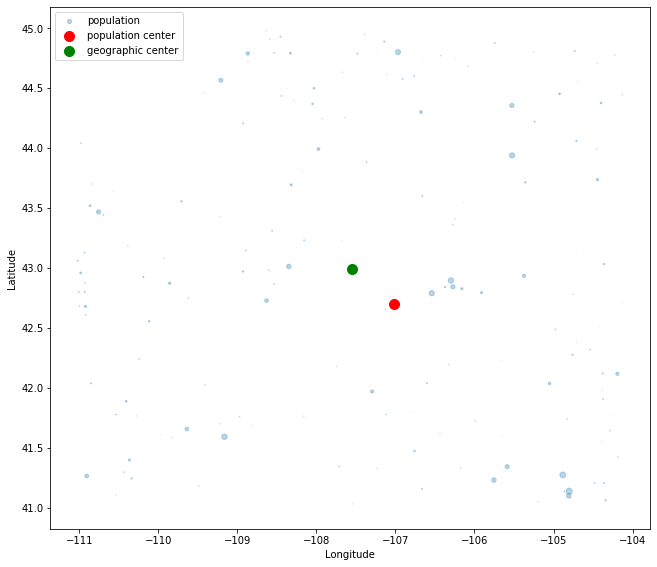

In [501]:
state_names = get_state_names()
geo_data = get_geo_data()

for state, abbrev in state_names:
# state, abbrev = state_names[14]
    print(state, abbrev)
    geo_center = geo_data[state]
    soup = get_wpr_soup(state.replace(' ', '-'))
    
    pop_by_zip = get_pop_by_zip(soup)
    zip_by_latlong = get_zip_by_latlong(abbrev)
    joined_data = pop_by_zip.join(zip_by_latlong)
    joined_data = drop_null_values(joined_data)
    lat_avg, long_avg = find_com(joined_data)
    plot(joined_data)
    plt.scatter(long_avg, lat_avg, s=100, c='red',label='population center')
    plt.scatter(geo_center[1], geo_center[0], s=100, c='green', label='geographic center')
    plt.legend()
    plt.show()

In [460]:
# binwidth = 0.5
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3.75, 9.6], 'width_ratios': [10.75, 4]}, tight_layout=True)

# joined_data.plot(kind="scatter", x="Longitude", y="Latitude",
#        s=joined_data['pop']/1000, label="population",
#        alpha=0.3, ax=ax3, figsize=(10.75, 9.6)
# )
# ax3.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.3)
# ax3.grid()

# ax1.hist(joined_data['Longitude'], weights=joined_data['pop']/total_pop, bins=np.arange(-124.5, -114 + binwidth, binwidth), color='black', alpha=0.5)
# ax1.set_ylabel("Fraction of population")
# # ax1.set_xlim(-124.55, -113.80)
# ax1.grid()

# ax4.hist(joined_data['Latitude'], weights=joined_data['pop']/total_pop, bins=np.arange(32.5, 42 + binwidth, binwidth), orientation="horizontal", color='black', alpha=0.5)
# ax4.set_xlabel("Fraction of population")
# ax4.set_ylim(32.45, 42.05)
# ax4.grid()

# fig.tight_layout()
# ax2.set_axis_off()
# plt.savefig('ca_pop_dist.png')

*Thanks for reading!*